In [2]:
import numpy as np
import pandas as pd
import os
import datetime
import pyproj
from matplotlib import pyplot as plt
from sklearn import linear_model, svm, tree, neighbors, neural_network, ensemble
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
dt = datetime.datetime
from time import time

In [ ]:
os.chdir('Dummy/sf-bay-area-bike-share')

In [3]:
#データの読み込み
df_station = pd.read_csv('station.csv')
df_trip = pd.read_csv('trip.csv')
df_weather = pd.read_csv('weather.csv')

In [4]:
#アメリカの郵便番号とGPS座標の対応表
zipcode = pd.read_table('zipcode.txt', delimiter=',')
zipcode = zipcode.rename(columns = {'ZIP': 'zip_code', 'LAT': 'lat', 'LNG': 'long'})

In [5]:
#郵便番号と都市名の対応辞書の作成
zipcode_city = {94041: 'Mountain View',
                94063: 'Redwood City',
                94107: 'San Francisco',
                94301: 'Palo Alto',
                95113: 'San Jose'}

In [6]:
#時間データの変換⇒datetime形式へ
temp1 = df_trip['start_date'].apply(lambda x: dt.strptime(x,'%m/%d/%Y %H:%M'))
temp2 = df_trip['end_date'].apply(lambda x: dt.strptime(x,'%m/%d/%Y %H:%M'))
#年、月、日、時間、曜日の抽出
df_trip['date'] = temp1.apply(lambda x: datetime.date(x.year, x.month, x.day))
df_trip['Year'] = temp1.apply(lambda x: x.year)
df_trip['Month'] = temp1.apply(lambda x: x.month)
df_trip['Day'] = temp1.apply(lambda x: x.day)
df_trip['Hour'] = temp1.apply(lambda x: x.hour)
df_trip['Weekday'] = temp1.apply(lambda x: x.weekday())

In [7]:
#継続時間のMin単位化
df_trip['duration (Min)'] = (df_trip['duration'] / 60).round(3)

In [8]:
#天気データの日付をdatetime化
temp3 = df_weather['date'].apply(lambda x: dt.strptime(x,'%m/%d/%Y'))
df_weather['date'] = temp3.apply(lambda x: datetime.date(x.year, x.month, x.day))

In [9]:
df_station = df_station.rename(columns = {'id': 'start_station_id'})
station_install_date = df_station.installation_date
df_station = df_station.drop('installation_date', axis=1)

tripデータとstationデータの結合<br>

In [10]:
df_trip_station = pd.merge(df_trip, df_station, on='start_station_id', how='left')

天気のデータに都市名フラグを付ける、zipcodeの辞書をマップ<br>

In [11]:
df_weather['city'] = df_weather.zip_code.map(zipcode_city)

天気の欠損値を補間、時系列なので、前の値で補間を利用<br>

In [12]:
df_weather.events = df_weather.events.fillna('No_RainForg')
df_weather.events = df_weather.events.str.replace('rain', 'Rain')

fillna_list = ['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
               'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
               'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
               'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles','max_wind_Speed_mph',
               'mean_wind_speed_mph', 'cloud_cover', 'wind_dir_degrees', 'precipitation_inches']

for fillna in fillna_list:
    df_weather[fillna] = df_weather[fillna].fillna(method = 'pad')

tripデータとstationデータと天気データの結合<br>
名前はdf_all<br>

In [13]:
df_all = pd.merge(df_trip_station, df_weather, on =['date', 'city'], how ='left')

"events"のNaNはどうやら晴れの日を指す模様（雨、雷雨、曇り以外）、なので'No_RainFog'で欠損値補完<br>

In [14]:
df_all.events = df_all.events.fillna('No_RainForg')

平日と休日のフラグ分け<br>

In [15]:
def weekday(x):
    if x == 5 or x == 6:
        return 'Weekend'
    else:
        return 'Weekday'

４つの時間帯にフラグわけ：朝ラッシュ、昼、夜ラッシュ、夜<br>

In [16]:
def timezone(x):
    if x >= 6 and x <=10:
        return 'Morning Rushhour'
    elif x >= 16 and x <= 20:
        return 'Eveing Rushhour'
    elif x >= 11 and x <= 15:
        return 'Noon'
    else:
        return 'Night'

In [17]:
df_all['Weekflag'] = df_all.Weekday.apply(weekday)

In [18]:
df_all['Timezone'] = df_all.Hour.apply(timezone)

2013年8月から2015年8月3年分の月別需要状況のグラフ化<br>

In [19]:
trend = df_all.groupby('date').size().reset_index()
trend.columns = ['date', 'Frequency']
trend['YM'] = trend['date'].apply(lambda x: x.strftime('%Y%m'))

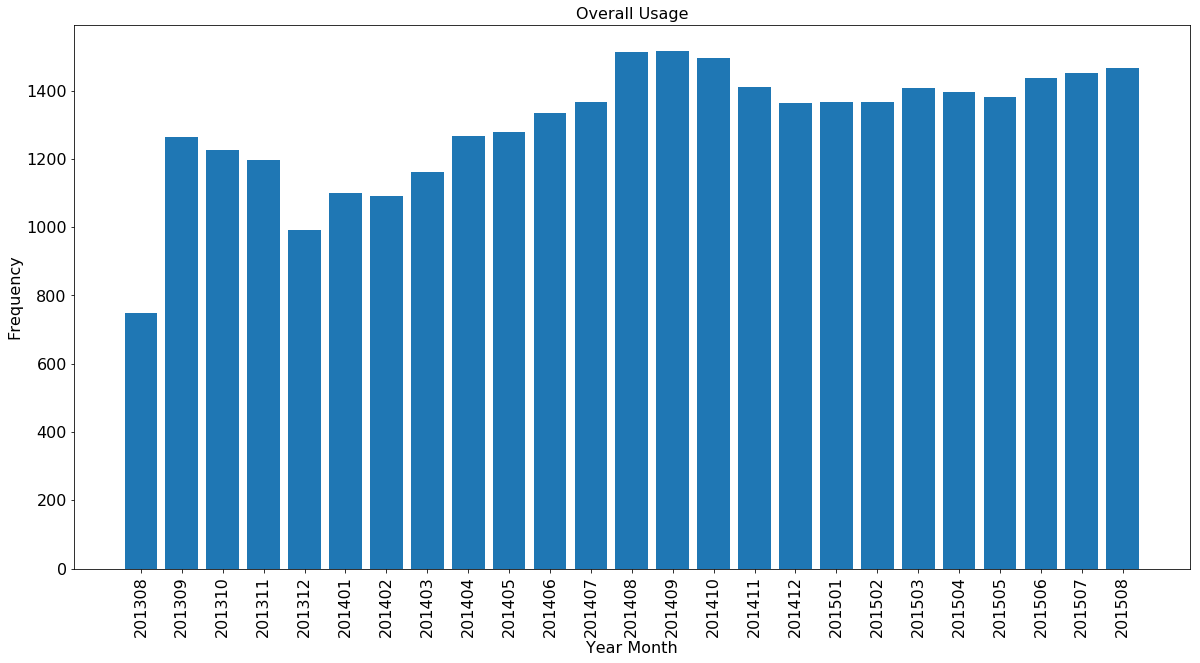

In [20]:
plt.clf()
fig = plt.figure(figsize=(20,10),facecolor='w')
plt.bar(trend.YM, trend.Frequency)

plt.xlabel('Year Month', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.title('Overall Usage', fontsize=16)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)

plt.savefig('fig1.png')
plt.show()
plt.close()

2013年から2014年中ころまでは順調に利用数が増えていっているがその後は頭打ち傾向<br>

都市ごとのステーションの利用数を見てみる<br>

In [21]:
city = df_all.groupby(['city', 'start_station_id']).size().reset_index()
city.columns = ['city', 'id', 'Frequency']

In [22]:
test = city[city.city == 'Mountain View']
test2 = city[city.city == 'Redwood City']
test3 = city[city.city == 'San Francisco']
test4 = city[city.city == 'Palo Alto']
test5 = city[city.city == 'San Jose']

test.id = test['id'].apply(lambda x: 'id_' + str(x))
test2.id = test2['id'].apply(lambda x: 'id_' + str(x))
test3.id = test3['id'].apply(lambda x: 'id_' + str(x))
test4.id = test4['id'].apply(lambda x: 'id_' + str(x))
test5.id = test5['id'].apply(lambda x: 'id_' + str(x))

C:\Users\zhaow\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


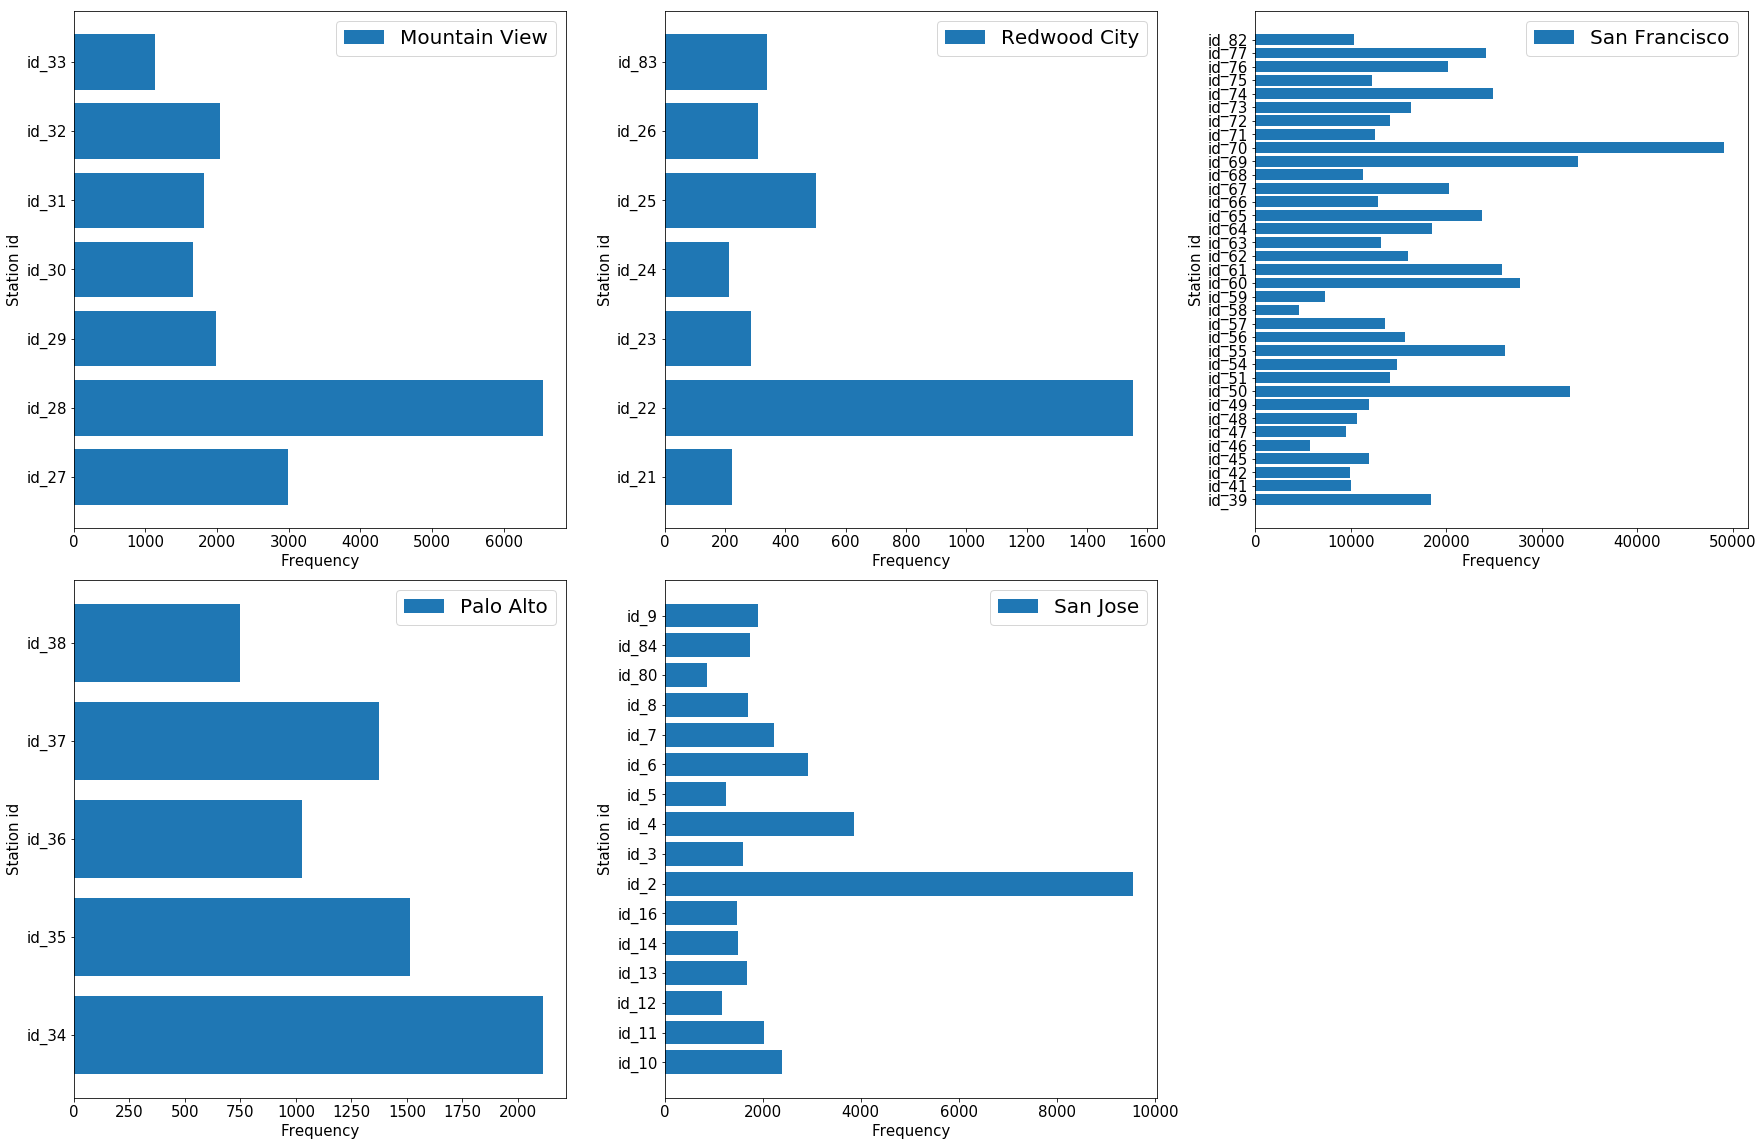

In [23]:
plt.clf()
fig = plt.figure(figsize=(30,20),facecolor='w')

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax1.barh(test.id, test.Frequency, label = 'Mountain View', align="center")
ax2.barh(test2.id, test2.Frequency, label = 'Redwood City', align="center")
ax3.barh(test3.id, test3.Frequency, label = 'San Francisco', align="center")
ax4.barh(test4.id, test4.Frequency, label = 'Palo Alto', align="center")
ax5.barh(test5.id, test5.Frequency, label = 'San Jose', align="center")

ax1.set_xlabel('Frequency', fontsize = 15)
ax2.set_xlabel('Frequency', fontsize = 15)
ax3.set_xlabel('Frequency', fontsize = 15)
ax4.set_xlabel('Frequency', fontsize = 15)
ax5.set_xlabel('Frequency', fontsize = 15)

ax1.set_ylabel('Station id', fontsize = 15)
ax2.set_ylabel('Station id', fontsize = 15)
ax3.set_ylabel('Station id', fontsize = 15)
ax4.set_ylabel('Station id', fontsize = 15)
ax5.set_ylabel('Station id', fontsize = 15)

ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax3.tick_params(labelsize=15)
ax4.tick_params(labelsize=15)
ax5.tick_params(labelsize=15)

#ax1.set_xticklabels(list(test.station_id))
#ax2.set_xticklabels(list(test2.station_id))
#ax3.set_xticklabels(list(test3.station_id))
#ax4.set_xticklabels(list(test4.station_id))
#ax5.set_xticklabels(list(test5.station_id))

plt.subplots_adjust(wspace=0.2, hspace=0.1)

ax1.legend(loc = 'best',fontsize=20)
ax2.legend(loc = 'best',fontsize=20)
ax3.legend(loc = 'best',fontsize=20)
ax4.legend(loc = 'best',fontsize=20)
ax5.legend(loc = 'best',fontsize=20)

plt.savefig('fig2.png')
plt.show()
plt.close()

都市やステーションごとに利用回数が大きく異なる、ダウンタウンでは利用数が多く、学生街では少ない、差が50倍近く開いている<br>

次に、各ステーションのdock数を確認してみる<br>

In [24]:
dock = df_station.groupby(['city', 'start_station_id'])['dock_count'].sum().reset_index()
dock.columns = ['city', 'id', 'docks']

In [25]:
test = dock[dock.city == 'Mountain View']
test2 = dock[dock.city == 'Redwood City']
test3 = dock[dock.city == 'San Francisco']
test4 = dock[dock.city == 'Palo Alto']
test5 = dock[dock.city == 'San Jose']

test.id = test['id'].apply(lambda x: 'id_' + str(x))
test2.id = test2['id'].apply(lambda x: 'id_' + str(x))
test3.id = test3['id'].apply(lambda x: 'id_' + str(x))
test4.id = test4['id'].apply(lambda x: 'id_' + str(x))
test5.id = test5['id'].apply(lambda x: 'id_' + str(x))

C:\Users\zhaow\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


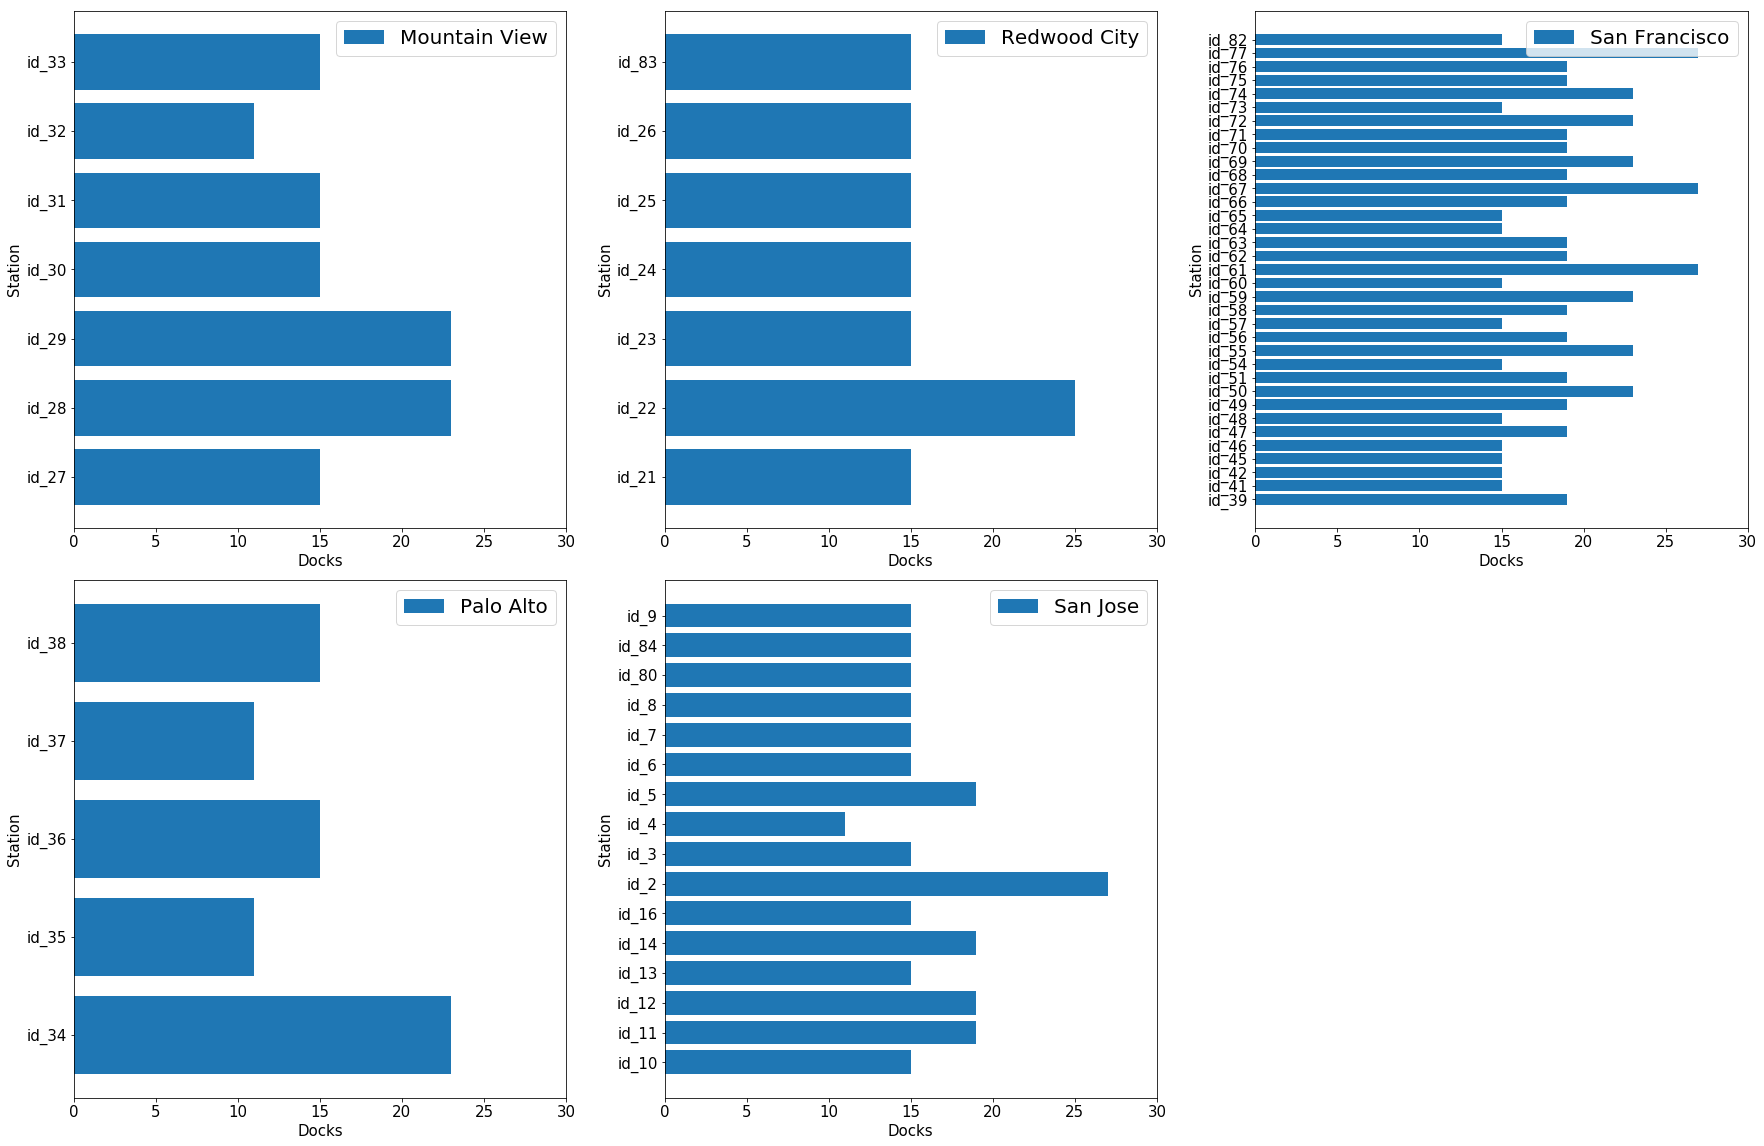

In [26]:
plt.clf()
fig = plt.figure(figsize=(30,20),facecolor='w')

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

ax1.barh(test.id, test.docks, label = 'Mountain View', align="center")
ax2.barh(test2.id, test2.docks, label = 'Redwood City', align="center")
ax3.barh(test3.id, test3.docks, label = 'San Francisco', align="center")
ax4.barh(test4.id, test4.docks, label = 'Palo Alto', align="center")
ax5.barh(test5.id, test5.docks, label = 'San Jose', align="center")

ax1.set_xlabel('Docks', fontsize = 15)
ax2.set_xlabel('Docks', fontsize = 15)
ax3.set_xlabel('Docks', fontsize = 15)
ax4.set_xlabel('Docks', fontsize = 15)
ax5.set_xlabel('Docks', fontsize = 15)

ax1.set_ylabel('Station', fontsize = 15)
ax2.set_ylabel('Station', fontsize = 15)
ax3.set_ylabel('Station', fontsize = 15)
ax4.set_ylabel('Station', fontsize = 15)
ax5.set_ylabel('Station', fontsize = 15)

ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax3.tick_params(labelsize=15)
ax4.tick_params(labelsize=15)
ax5.tick_params(labelsize=15)

ax1.set_xlim(0, 30)
ax2.set_xlim(0, 30)
ax3.set_xlim(0, 30)
ax4.set_xlim(0, 30)
ax5.set_xlim(0, 30)

ax1.legend(loc = 'best', fontsize=20)
ax2.legend(loc = 'best', fontsize=20)
ax3.legend(loc = 'best', fontsize=20)
ax4.legend(loc = 'best', fontsize=20)
ax5.legend(loc = 'best', fontsize=20)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.show()

しかし、ステーションの数を見ると、需要が多いサンフランシスコでも多くて25程度、一方需要が少ないPalo Altoでも20程度あり、稼働率がひっ迫しているものと余っているものがあると思われる<br>


次に、都市別の曜日別需要を見てみた<br>

In [27]:
temp = df_all.groupby(['city', 'Weekday']).size()
temp = temp.reset_index()
temp.columns = ['city', 'Weekday', 'Frequency']

In [28]:
weekday_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [29]:
test = temp[temp.city == 'Mountain View']
test2 = temp[temp.city == 'Redwood City']
test3 = temp[temp.city == 'San Francisco']
test4 = temp[temp.city == 'Palo Alto']
test5 = temp[temp.city == 'San Jose']

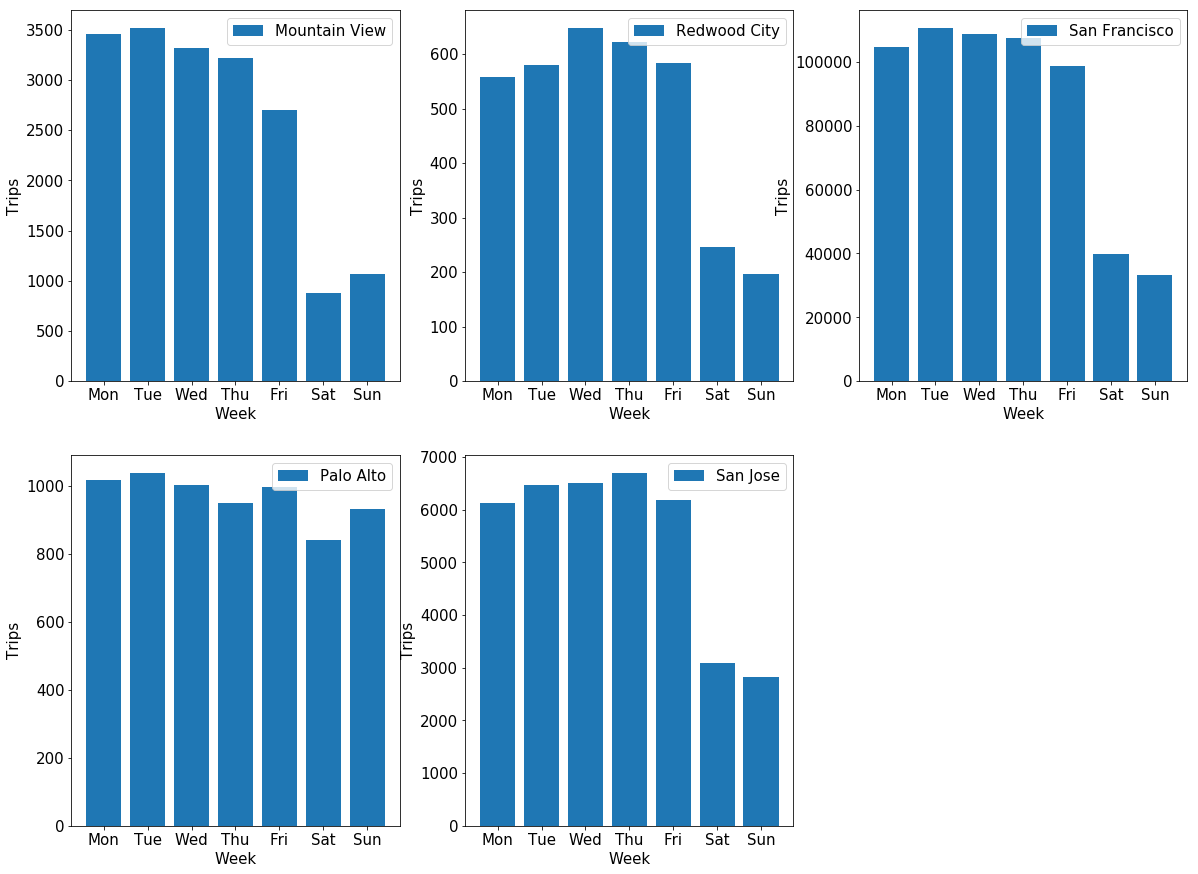

In [30]:
plt.clf()
fig = plt.figure(figsize=(20,15), facecolor='w')

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

ax1.bar(test.Weekday, test.Frequency, label = 'Mountain View', align="center")
ax2.bar(test2.Weekday, test2.Frequency, label = 'Redwood City', align="center")
ax3.bar(test3.Weekday, test3.Frequency, label = 'San Francisco', align="center")
ax4.bar(test4.Weekday, test4.Frequency, label = 'Palo Alto', align="center")
ax5.bar(test5.Weekday, test5.Frequency, label = 'San Jose', align="center")

ax1.set_xticks(range(0, 7))
ax2.set_xticks(range(0, 7))
ax3.set_xticks(range(0, 7))
ax4.set_xticks(range(0, 7))
ax5.set_xticks(range(0, 7))

ax1.set_xticklabels(['Mon','Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax2.set_xticklabels(['Mon','Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_xticklabels(['Mon','Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax4.set_xticklabels(['Mon','Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax5.set_xticklabels(['Mon','Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax1.set_xlabel('Week', fontsize = 15)
ax2.set_xlabel('Week', fontsize = 15)
ax3.set_xlabel('Week', fontsize = 15)
ax4.set_xlabel('Week', fontsize = 15)
ax5.set_xlabel('Week', fontsize = 15)

ax1.set_ylabel('Trips', fontsize = 15)
ax2.set_ylabel('Trips', fontsize = 15)
ax3.set_ylabel('Trips', fontsize = 15)
ax4.set_ylabel('Trips', fontsize = 15)
ax5.set_ylabel('Trips', fontsize = 15)

ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
ax3.tick_params(labelsize=15)
ax4.tick_params(labelsize=15)
ax5.tick_params(labelsize=15)


ax1.legend(loc = 'best', fontsize=15)
ax2.legend(loc = 'best', fontsize=15)
ax3.legend(loc = 'best', fontsize=15)
ax4.legend(loc = 'best', fontsize=15)
ax5.legend(loc = 'best', fontsize=15)

plt.show()

平日は利用回数が多い、週末は下がる<br>
どうもCityによって週末の下がり方が違う<br>
シスコやサンノゼなどダウンタウンは週末の需要減が顕著<br>
学生街のPalo Alto週末はあまり減らない<br>

In [31]:
hour = df_all.groupby(['city','Weekday', 'Hour']).size()
hour = hour.reset_index()
hour.columns = ['city', 'Weekday', 'Hour', 'Frequency']

In [32]:
test = hour[hour.city == 'Mountain View']
test2 = hour[hour.city == 'Redwood City']
test3 = hour[hour.city == 'San Francisco']
test4 = hour[hour.city == 'Palo Alto']
test5 = hour[hour.city == 'San Jose']

In [33]:
test_wkend = test[(test.Weekday == 5) | (test.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test2_wkend = test2[(test2.Weekday == 5) | (test2.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test3_wkend = test3[(test3.Weekday == 5) | (test3.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test4_wkend = test4[(test4.Weekday == 5) | (test4.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test5_wkend = test5[(test5.Weekday == 5) | (test5.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()

In [34]:
test_wkday = test[~(test.Weekday == 5) | (test.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test2_wkday = test2[~(test2.Weekday == 5) | (test2.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test3_wkday = test3[~(test3.Weekday == 5) | (test3.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test4_wkday = test4[~(test4.Weekday == 5) | (test4.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()
test5_wkday = test5[~(test5.Weekday == 5) | (test5.Weekday == 6)].groupby('Hour').Frequency.sum().reset_index()

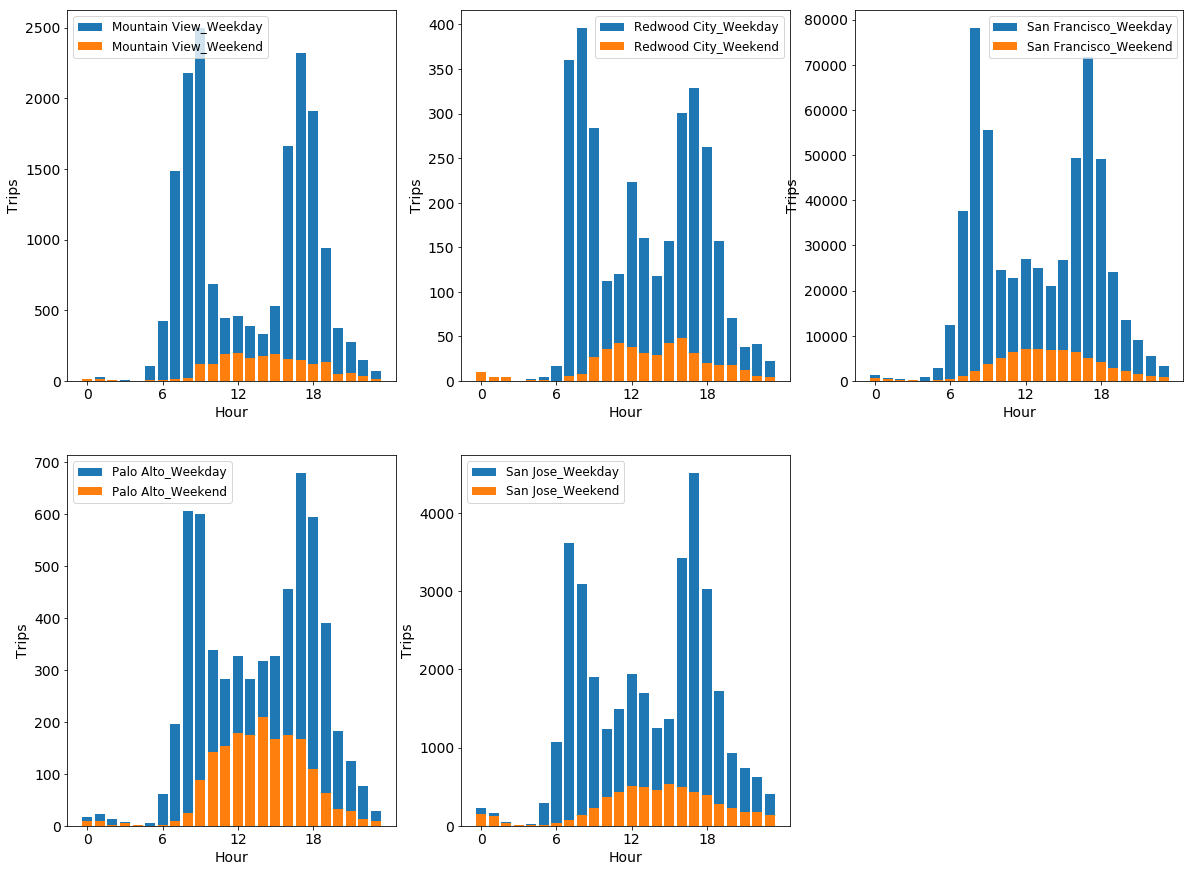

In [35]:
plt.clf()
fig = plt.figure(figsize=(20,15), facecolor='w')

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

ax1.bar(test_wkday.Hour, test_wkday.Frequency, label = 'Mountain View_Weekday', align="center")
ax2.bar(test2_wkday.Hour, test2_wkday.Frequency, label = 'Redwood City_Weekday', align="center")
ax3.bar(test3_wkday.Hour, test3_wkday.Frequency, label = 'San Francisco_Weekday', align="center")
ax4.bar(test4_wkday.Hour, test4_wkday.Frequency, label = 'Palo Alto_Weekday', align="center")
ax5.bar(test5_wkday.Hour, test5_wkday.Frequency, label = 'San Jose_Weekday', align="center")

ax1.bar(test_wkend.Hour, test_wkend.Frequency, label = 'Mountain View_Weekend', align="center")
ax2.bar(test2_wkend.Hour, test2_wkend.Frequency, label = 'Redwood City_Weekend', align="center")
ax3.bar(test3_wkend.Hour, test3_wkend.Frequency, label = 'San Francisco_Weekend', align="center")
ax4.bar(test4_wkend.Hour, test4_wkend.Frequency, label = 'Palo Alto_Weekend', align="center")
ax5.bar(test5_wkend.Hour, test5_wkend.Frequency, label = 'San Jose_Weekend', align="center")

ax1.set_xticks([0, 6, 12, 18])
ax2.set_xticks([0, 6, 12, 18])
ax3.set_xticks([0, 6, 12, 18])
ax4.set_xticks([0, 6, 12, 18])
ax5.set_xticks([0, 6, 12, 18])

ax1.legend(loc = 'best', fontsize=12)
ax2.legend(loc = 'best', fontsize=12)
ax3.legend(loc = 'best', fontsize=12)
ax4.legend(loc = 'best', fontsize=12)
ax5.legend(loc = 'best', fontsize=12)

ax1.set_xlabel('Hour', fontsize = 14)
ax2.set_xlabel('Hour', fontsize = 14)
ax3.set_xlabel('Hour', fontsize = 14)
ax4.set_xlabel('Hour', fontsize = 14)
ax5.set_xlabel('Hour', fontsize = 14)

ax1.set_ylabel('Trips', fontsize = 14)
ax2.set_ylabel('Trips', fontsize = 14)
ax3.set_ylabel('Trips', fontsize = 14)
ax4.set_ylabel('Trips', fontsize = 14)
ax5.set_ylabel('Trips', fontsize = 14)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax5.tick_params(labelsize=14)

plt.show()

In [36]:
Month = df_all.groupby(['city','Month']).size()
Month = Month.reset_index()
Month.columns = ['city', 'Month', 'Frequency']

In [37]:
test = Month[Month.city == 'Mountain View']
test2 = Month[Month.city == 'Redwood City']
test3 = Month[Month.city == 'San Francisco']
test4 = Month[Month.city == 'Palo Alto']
test5 = Month[Month.city == 'San Jose']

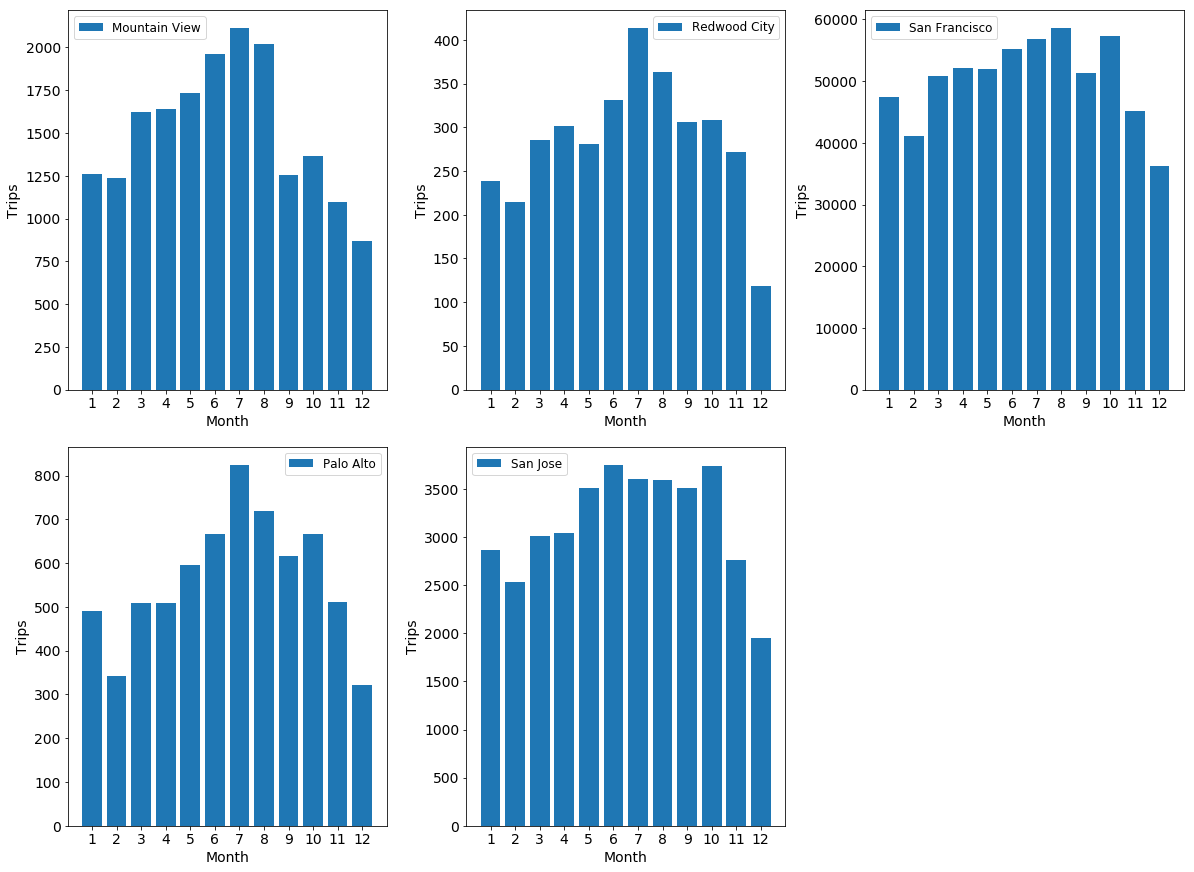

In [38]:
plt.clf()
fig = plt.figure(figsize=(20,15), facecolor='w')

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

ax1.bar(test.Month, test.Frequency, label = 'Mountain View', align="center")
ax2.bar(test2.Month, test2.Frequency, label = 'Redwood City', align="center")
ax3.bar(test3.Month, test3.Frequency, label = 'San Francisco', align="center")
ax4.bar(test4.Month, test4.Frequency, label = 'Palo Alto', align="center")
ax5.bar(test5.Month, test5.Frequency, label = 'San Jose', align="center")

ax1.set_xticks(range(1, 13))
ax2.set_xticks(range(1, 13))
ax3.set_xticks(range(1, 13))
ax4.set_xticks(range(1, 13))
ax5.set_xticks(range(1, 13))

ax1.set_xlabel('Month', fontsize = 14)
ax2.set_xlabel('Month', fontsize = 14)
ax3.set_xlabel('Month', fontsize = 14)
ax4.set_xlabel('Month', fontsize = 14)
ax5.set_xlabel('Month', fontsize = 14)

ax1.set_ylabel('Trips', fontsize = 14)
ax2.set_ylabel('Trips', fontsize = 14)
ax3.set_ylabel('Trips', fontsize = 14)
ax4.set_ylabel('Trips', fontsize = 14)
ax5.set_ylabel('Trips', fontsize = 14)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax5.tick_params(labelsize=14)

ax1.legend(loc = 'best', fontsize=12)
ax2.legend(loc = 'best', fontsize=12)
ax3.legend(loc = 'best', fontsize=12)
ax4.legend(loc = 'best', fontsize=12)
ax5.legend(loc = 'best', fontsize=12)

plt.subplots_adjust(wspace=0.25, hspace=0.15)

plt.show()

全体として夏季、特に7月の利用率が高く、冬季、特に２月の利用が少ない<br>

In [39]:
weather = df_all.groupby(['city', 'events']).size().reset_index()
weather.columns = ['city', 'events', 'Frequency']

In [40]:
test = weather[weather.city == 'Mountain View']
test2 = weather[weather.city == 'Redwood City']
test3 = weather[weather.city == 'San Francisco']
test4 = weather[weather.city == 'Palo Alto']
test5 = weather[weather.city == 'San Jose']

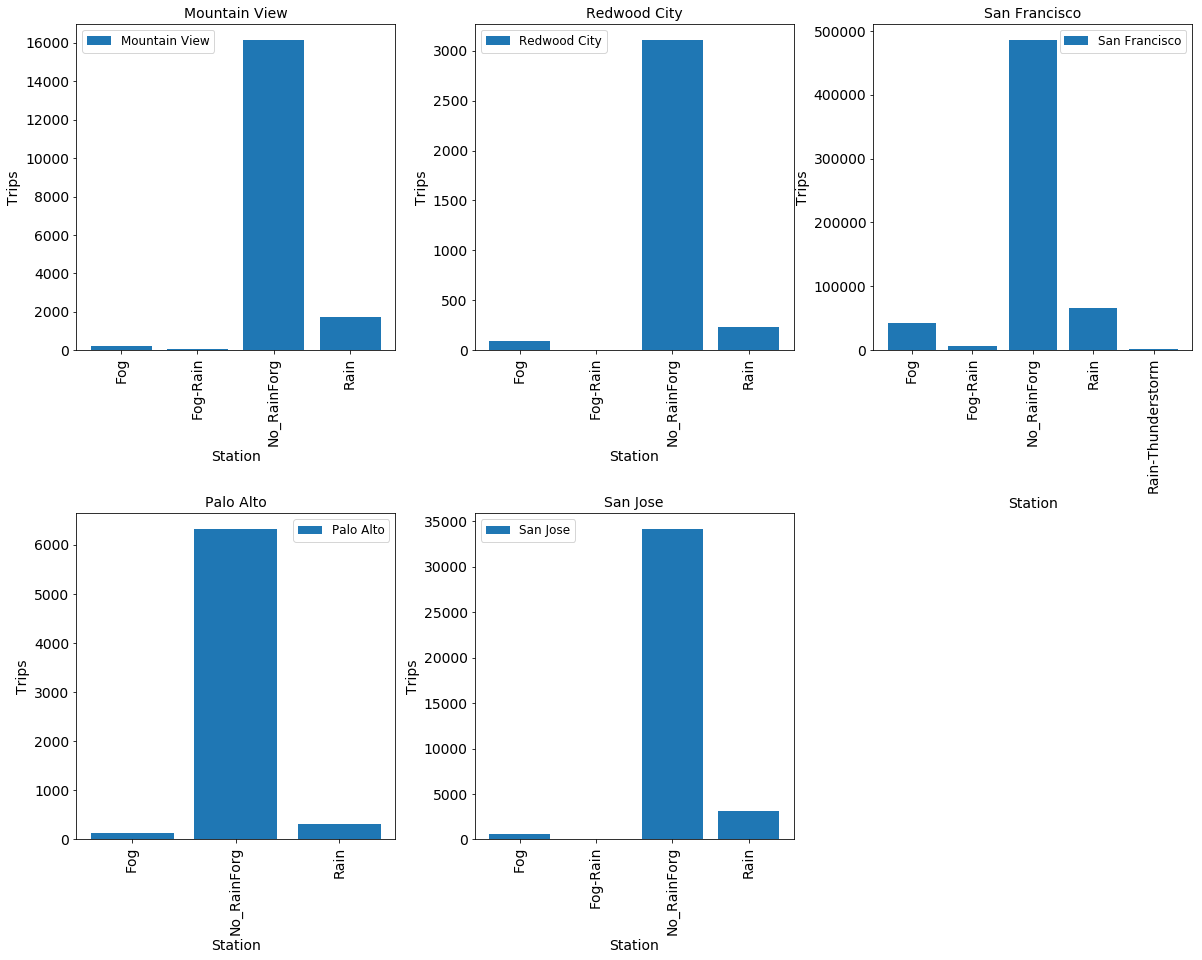

In [41]:
plt.clf()
fig = plt.figure(figsize=(20, 15), facecolor='w')

ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)

ax1.bar(test.events, test.Frequency, label = 'Mountain View', align="center")
ax2.bar(test2.events, test2.Frequency, label = 'Redwood City', align="center")
ax3.bar(test3.events, test3.Frequency, label = 'San Francisco', align="center")
ax4.bar(test4.events, test4.Frequency, label = 'Palo Alto', align="center")
ax5.bar(test5.events, test5.Frequency, label = 'San Jose', align="center")

ax1.set_xticklabels(test.events, rotation='vertical')
ax2.set_xticklabels(test2.events, rotation='vertical')
ax3.set_xticklabels(test3.events, rotation='vertical')
ax4.set_xticklabels(test4.events, rotation='vertical')
ax5.set_xticklabels(test5.events, rotation='vertical')

ax1.set_title('Mountain View', fontsize=14)
ax2.set_title('Redwood City', fontsize=14)
ax3.set_title('San Francisco', fontsize=14)
ax4.set_title('Palo Alto', fontsize=14)
ax5.set_title('San Jose', fontsize=14)

ax1.set_ylabel('Trips', fontsize = 14)
ax2.set_ylabel('Trips', fontsize = 14)
ax3.set_ylabel('Trips', fontsize = 14)
ax4.set_ylabel('Trips', fontsize = 14)
ax5.set_ylabel('Trips', fontsize = 14)

ax1.set_xlabel('Station', fontsize = 14)
ax2.set_xlabel('Station', fontsize = 14)
ax3.set_xlabel('Station', fontsize = 14)
ax4.set_xlabel('Station', fontsize = 14)
ax5.set_xlabel('Station', fontsize = 14)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax5.tick_params(labelsize=14)

ax1.legend(loc = 'best', fontsize=12)
ax2.legend(loc = 'best', fontsize=12)
ax3.legend(loc = 'best', fontsize=12)
ax4.legend(loc = 'best', fontsize=12)
ax5.legend(loc = 'best', fontsize=12)

plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.show()

晴れの日の利用率は圧倒的に高い<br>

In [42]:
x = df_all.groupby(['city', 'Weekflag', 'date']).mean_temperature_f.mean().reset_index()
y = df_all.groupby(['city', 'Weekflag', 'date']).size().reset_index()
x.columns = ['city', 'Weekflag', 'date', 'mean_temperature']
y.columns = ['city', 'Weekflag', 'date', 'Frequency']

In [43]:
temper = list(0 for i in range(6))
Needs = list(0 for i in range(6))

In [44]:
temper[0] = x[(x['city'] == 'Mountain View') & (x['Weekflag'] == 'Weekday')].mean_temperature
temper[1] = x[(x['city'] == 'Redwood City') & (x['Weekflag'] == 'Weekday')].mean_temperature
temper[2] = x[(x['city'] == 'San Francisco') & (x['Weekflag'] == 'Weekday')].mean_temperature
temper[3] = x[(x['city'] == 'Palo Alto') & (x['Weekflag'] == 'Weekday')].mean_temperature
temper[4] = x[(x['city'] == 'San Jose') & (x['Weekflag'] == 'Weekday')].mean_temperature

Needs[0] = y[(y['city'] == 'Mountain View') & (y['Weekflag'] == 'Weekday')].Frequency
Needs[1] = y[(y['city'] == 'Redwood City') & (y['Weekflag'] == 'Weekday')].Frequency
Needs[2] = y[(y['city'] == 'San Francisco') & (y['Weekflag'] == 'Weekday')].Frequency
Needs[3] = y[(y['city'] == 'Palo Alto') & (y['Weekflag'] == 'Weekday')].Frequency
Needs[4] = y[(y['city'] == 'San Jose') & (y['Weekflag'] == 'Weekday')].Frequency

In [45]:
reg1 = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression()
reg3 = linear_model.LinearRegression()
reg4 = linear_model.LinearRegression()
reg5 = linear_model.LinearRegression()
modellist = [reg1, reg2, reg3, reg4, reg5]

In [46]:
temper[0][temper[0].isnull()]

Series([], Name: mean_temperature, dtype: float64)

In [47]:
temper[0].iloc[436, ]
Needs[0].iloc[436, ]

33

In [48]:
temper[0] = temper[0].drop(436).reset_index(drop = True)
Needs[0] = Needs[0].drop(436).reset_index(drop = True)

気温と需要数の線形回帰<br>

In [49]:
i = 0
for model in modellist:
    model.fit(temper[i].reshape(-1, 1), Needs[i])
    i += 1

C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages

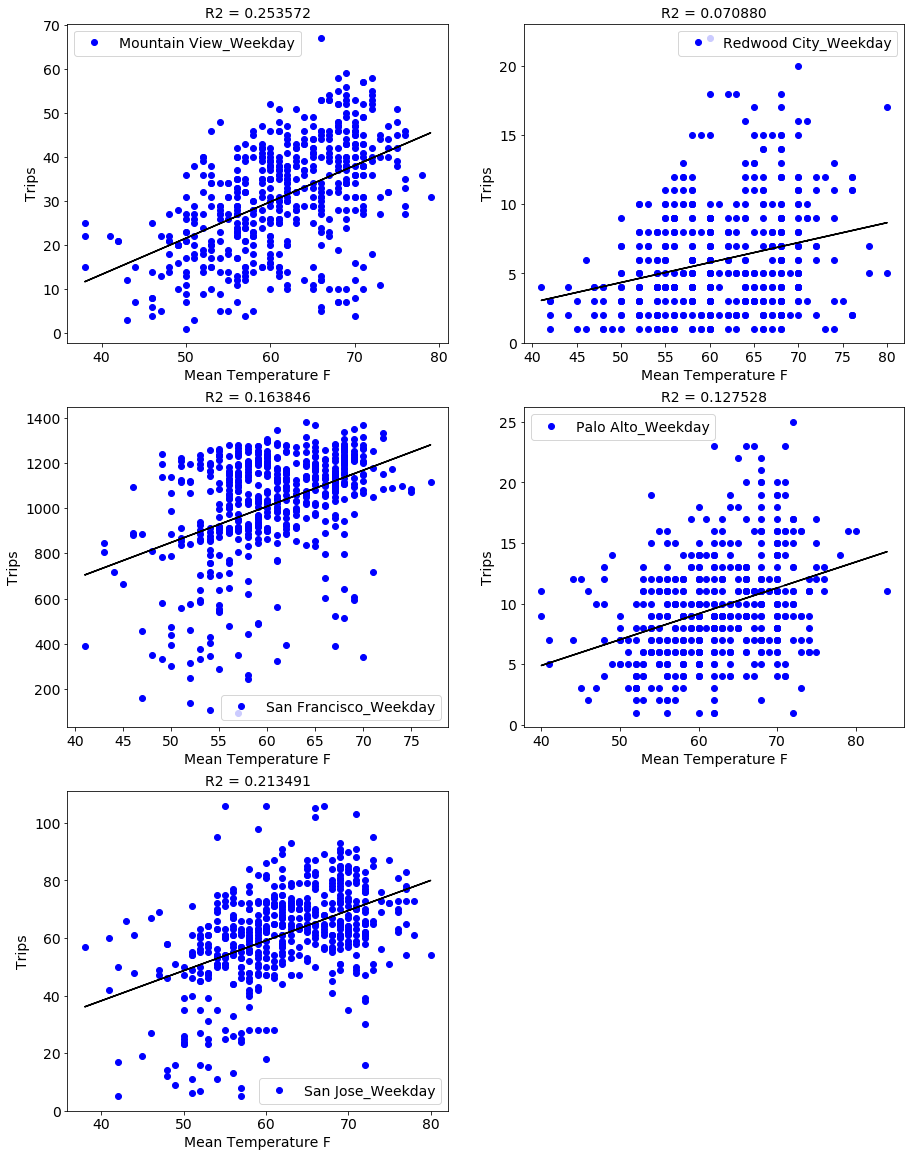

In [50]:
plt.clf()
fig = plt.figure(figsize=(15,20), facecolor='w')

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(temper[0], Needs[0], 'o', color='b', label = 'Mountain View_Weekday')
ax2.plot(temper[1], Needs[1], 'o', color='b', label = 'Redwood City_Weekday')
ax3.plot(temper[2], Needs[2], 'o', color='b', label = 'San Francisco_Weekday')
ax4.plot(temper[3], Needs[3], 'o', color='b', label = 'Palo Alto_Weekday')
ax5.plot(temper[4], Needs[4], 'o', color='b', label = 'San Jose_Weekday')

ax1.plot(temper[0], reg1.predict(temper[0].reshape(-1, 1)), '-', color = 'black')
ax2.plot(temper[1], reg2.predict(temper[1].reshape(-1, 1)), '-', color = 'black')
ax3.plot(temper[2], reg3.predict(temper[2].reshape(-1, 1)), '-', color = 'black')
ax4.plot(temper[3], reg4.predict(temper[3].reshape(-1, 1)), '-', color = 'black')
ax5.plot(temper[4], reg5.predict(temper[4].reshape(-1, 1)), '-', color = 'black')

ax1.set_xlabel('Mean Temperature F', fontsize=14)
ax2.set_xlabel('Mean Temperature F', fontsize=14)
ax3.set_xlabel('Mean Temperature F', fontsize=14)
ax4.set_xlabel('Mean Temperature F', fontsize=14)
ax5.set_xlabel('Mean Temperature F', fontsize=14)

ax1.set_ylabel('Trips', fontsize=14)
ax2.set_ylabel('Trips', fontsize=14)
ax3.set_ylabel('Trips', fontsize=14)
ax4.set_ylabel('Trips', fontsize=14)
ax5.set_ylabel('Trips', fontsize=14)

ax1.set_title('R2 = %f' % reg1.score(temper[0].reshape(-1, 1), Needs[0]), fontsize=14)
ax2.set_title('R2 = %f' % reg2.score(temper[1].reshape(-1, 1), Needs[1]), fontsize=14)
ax3.set_title('R2 = %f' % reg3.score(temper[2].reshape(-1, 1), Needs[2]), fontsize=14)
ax4.set_title('R2 = %f' % reg4.score(temper[3].reshape(-1, 1), Needs[3]), fontsize=14)
ax5.set_title('R2 = %f' % reg5.score(temper[4].reshape(-1, 1), Needs[4]), fontsize=14)

ax1.legend(loc = 'best', fontsize=14)
ax2.legend(loc = 'best', fontsize=14)
ax3.legend(loc = 'best', fontsize=14)
ax4.legend(loc = 'best', fontsize=14)
ax5.legend(loc = 'best', fontsize=14)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax5.tick_params(labelsize=14)

plt.show()

基本と需要は少し正の相関がある模様<br>

In [51]:
temper2 = list(0 for i in range(6))
Needs2 = list(0 for i in range(6))

In [52]:
temper2[0] = x[(x['city'] == 'Mountain View') & (x['Weekflag'] == 'Weekend')].mean_temperature
temper2[1] = x[(x['city'] == 'Redwood City') & (x['Weekflag'] == 'Weekend')].mean_temperature
temper2[2] = x[(x['city'] == 'San Francisco') & (x['Weekflag'] == 'Weekend')].mean_temperature
temper2[3] = x[(x['city'] == 'Palo Alto') & (x['Weekflag'] == 'Weekend')].mean_temperature
temper2[4] = x[(x['city'] == 'San Jose') & (x['Weekflag'] == 'Weekend')].mean_temperature

Needs2[0] = y[(y['city'] == 'Mountain View') & (y['Weekflag'] == 'Weekend')].Frequency
Needs2[1] = y[(y['city'] == 'Redwood City') & (y['Weekflag'] == 'Weekend')].Frequency
Needs2[2] = y[(y['city'] == 'San Francisco') & (y['Weekflag'] == 'Weekend')].Frequency
Needs2[3] = y[(y['city'] == 'Palo Alto') & (y['Weekflag'] == 'Weekend')].Frequency
Needs2[4] = y[(y['city'] == 'San Jose') & (y['Weekflag'] == 'Weekend')].Frequency

In [53]:
reg1 = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression()
reg3 = linear_model.LinearRegression()
reg4 = linear_model.LinearRegression()
reg5 = linear_model.LinearRegression()
modellist = [reg1, reg2, reg3, reg4, reg5]

In [54]:
print(temper2[0][temper2[0].isnull()])
print(temper2[3][temper2[3].isnull()])

Series([], Name: mean_temperature, dtype: float64)
Series([], Name: mean_temperature, dtype: float64)


In [55]:
temper2[0] = temper2[0].drop(690).drop(691).reset_index(drop = True)
Needs2[0] = Needs2[0].drop(690).drop(691).reset_index(drop = True)
temper2[3] = temper2[3].drop(1440).reset_index(drop = True)
Needs2[3] = Needs2[3].drop(1440).reset_index(drop = True)

In [56]:
i = 0
for model in modellist:
    model.fit(temper2[i].reshape(-1, 1), Needs2[i])
    i += 1

C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\zhaow\Anaconda3\lib\site-packages

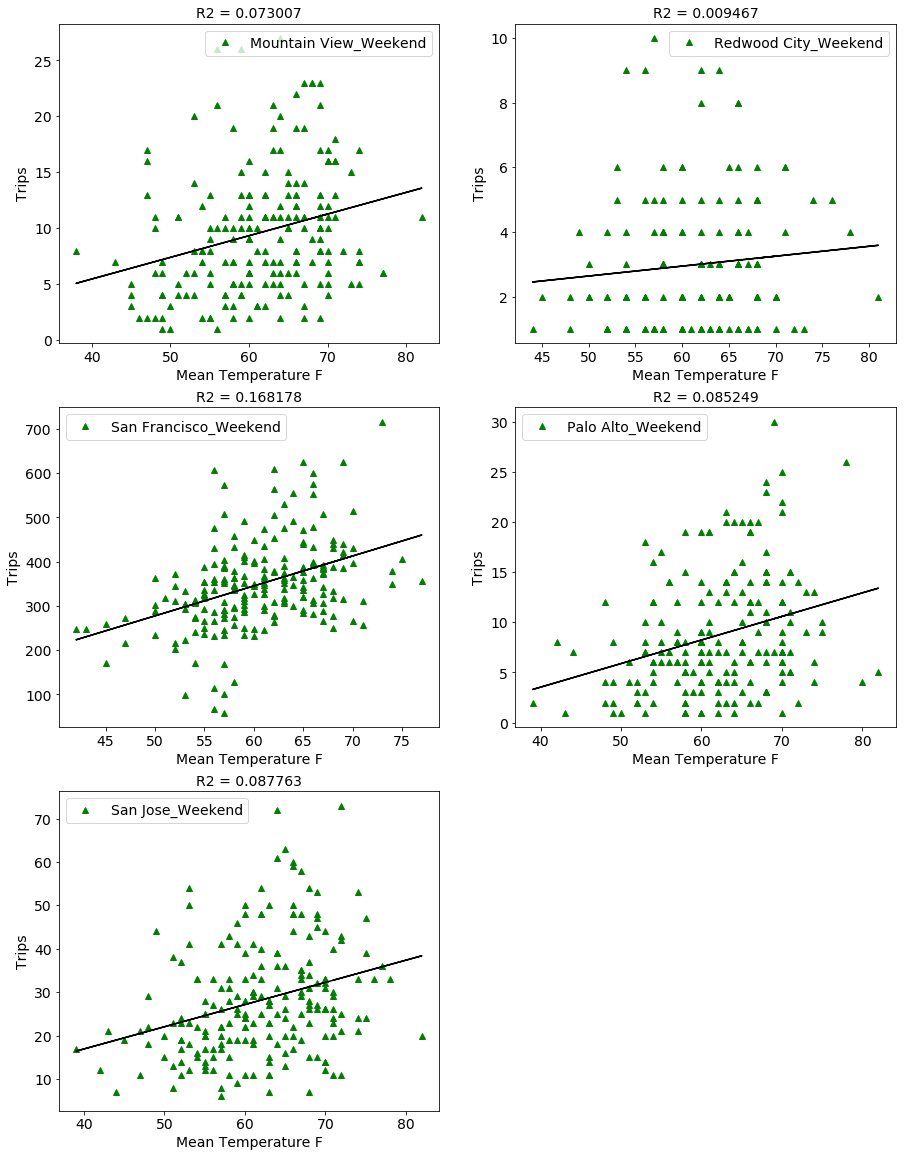

In [57]:
plt.clf()
fig = plt.figure(figsize=(15,20), facecolor='w')

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(temper2[0], Needs2[0], '^', color='g', label = 'Mountain View_Weekend')
ax2.plot(temper2[1], Needs2[1], '^', color='g', label = 'Redwood City_Weekend')
ax3.plot(temper2[2], Needs2[2], '^', color='g', label = 'San Francisco_Weekend')
ax4.plot(temper2[3], Needs2[3], '^', color='g', label = 'Palo Alto_Weekend')
ax5.plot(temper2[4], Needs2[4], '^', color='g', label = 'San Jose_Weekend')

ax1.plot(temper2[0], reg1.predict(temper2[0].reshape(-1, 1)), '-', color = 'black')
ax2.plot(temper2[1], reg2.predict(temper2[1].reshape(-1, 1)), '-', color = 'black')
ax3.plot(temper2[2], reg3.predict(temper2[2].reshape(-1, 1)), '-', color = 'black')
ax4.plot(temper2[3], reg4.predict(temper2[3].reshape(-1, 1)), '-', color = 'black')
ax5.plot(temper2[4], reg5.predict(temper2[4].reshape(-1, 1)), '-', color = 'black')

ax1.set_xlabel('Mean Temperature F', fontsize=14)
ax2.set_xlabel('Mean Temperature F', fontsize=14)
ax3.set_xlabel('Mean Temperature F', fontsize=14)
ax4.set_xlabel('Mean Temperature F', fontsize=14)
ax5.set_xlabel('Mean Temperature F', fontsize=14)

ax1.set_ylabel('Trips', fontsize=14)
ax2.set_ylabel('Trips', fontsize=14)
ax3.set_ylabel('Trips', fontsize=14)
ax4.set_ylabel('Trips', fontsize=14)
ax5.set_ylabel('Trips', fontsize=14)

ax1.set_title('R2 = %f' % reg1.score(temper2[0].reshape(-1, 1), Needs2[0]), fontsize=14)
ax2.set_title('R2 = %f' % reg2.score(temper2[1].reshape(-1, 1), Needs2[1]), fontsize=14)
ax3.set_title('R2 = %f' % reg3.score(temper2[2].reshape(-1, 1), Needs2[2]), fontsize=14)
ax4.set_title('R2 = %f' % reg4.score(temper2[3].reshape(-1, 1), Needs2[3]), fontsize=14)
ax5.set_title('R2 = %f' % reg5.score(temper2[4].reshape(-1, 1), Needs2[4]), fontsize=14)

ax1.legend(loc = 'best', fontsize=14)
ax2.legend(loc = 'best', fontsize=14)
ax3.legend(loc = 'best', fontsize=14)
ax4.legend(loc = 'best', fontsize=14)
ax5.legend(loc = 'best', fontsize=14)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax3.tick_params(labelsize=14)
ax4.tick_params(labelsize=14)
ax5.tick_params(labelsize=14)

plt.show()

In [58]:
x = df_all.groupby(['city', 'Weekflag', 'date']).mean_wind_speed_mph.mean().reset_index()
y = df_all.groupby(['city', 'Weekflag', 'date']).size().reset_index()
x.columns = ['city', 'Weekflag', 'date', 'mean_wind_speed_mph']
y.columns = ['city', 'Weekflag', 'date', 'Frequency']
wind = pd.concat([x, y.Frequency], axis=1)

In [59]:
wind = wind.dropna()

In [60]:
temper3 = list(0 for i in range(6))

In [61]:
temper3[0] = wind[(wind['city'] == 'Mountain View') & (wind['Weekflag'] == 'Weekday')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper3[1] = wind[(wind['city'] == 'Redwood City') & (wind['Weekflag'] == 'Weekday')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper3[2] = wind[(wind['city'] == 'San Francisco') & (wind['Weekflag'] == 'Weekday')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper3[3] = wind[(wind['city'] == 'Palo Alto') & (wind['Weekflag'] == 'Weekday')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper3[4] = wind[(wind['city'] == 'San Jose') & (wind['Weekflag'] == 'Weekday')].loc[:, ['mean_wind_speed_mph', 'Frequency']]

In [62]:
reg1 = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression()
reg3 = linear_model.LinearRegression()
reg4 = linear_model.LinearRegression()
reg5 = linear_model.LinearRegression()

modellist = [reg1, reg2, reg3, reg4, reg5]
pred = []

In [63]:
i = 0
for model in modellist:
    model.fit(temper3[i].loc[:, ['mean_wind_speed_mph']], temper3[i].Frequency)
    pred.append(model.predict(temper3[i].loc[:, ['mean_wind_speed_mph']]))
    i += 1

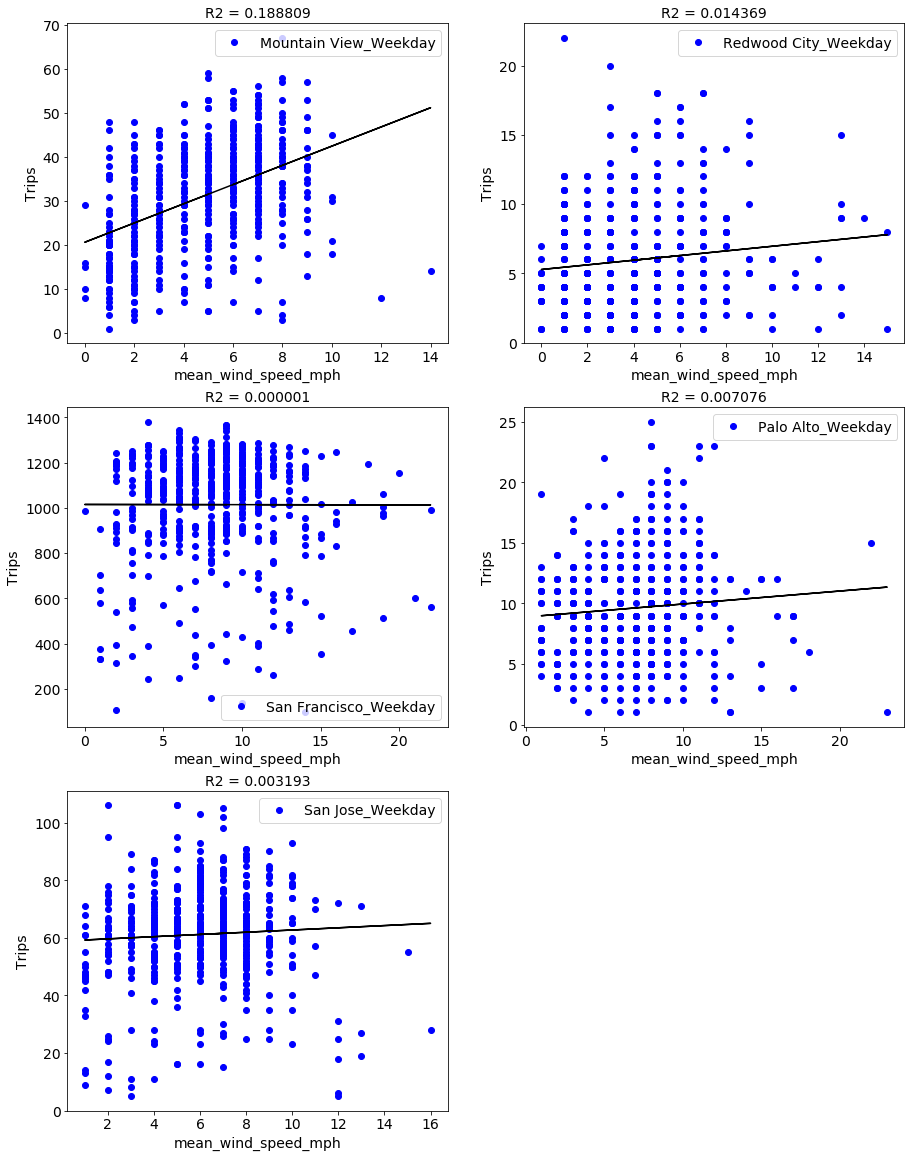

In [64]:
plt.clf()
fig = plt.figure(figsize=(15,20), facecolor='w')

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

plist = [ax1, ax2, ax3, ax4, ax5]
labellist = ['Mountain View_Weekday', 'Redwood City_Weekday', 'San Francisco_Weekday', 'Palo Alto_Weekday', 'San Jose_Weekday']
i = 0

for p in plist:
    p.plot(temper3[i].mean_wind_speed_mph, temper3[i].Frequency, 'o', color ='b', label = labellist[i])
    p.plot(temper3[i].mean_wind_speed_mph, pred[i], '-', color = 'black')
    p.set_xlabel('mean_wind_speed_mph', fontsize=14)
    p.set_ylabel('Trips', fontsize =14)
    p.set_title('R2 = %f' % modellist[i].score(temper3[i].loc[:, ['mean_wind_speed_mph']], temper3[i].Frequency),fontsize=14)
    p.legend(loc = 'best',fontsize =14)
    p.tick_params(labelsize=14)
    i += 1
    
plt.show()

風はあまり関係がない模様<br>

In [65]:
temper4 = list(0 for i in range(6))

In [66]:
temper4[0] = wind[(wind['city'] == 'Mountain View') & (wind['Weekflag'] == 'Weekend')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper4[1] = wind[(wind['city'] == 'Redwood City') & (wind['Weekflag'] == 'Weekend')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper4[2] = wind[(wind['city'] == 'San Francisco') & (wind['Weekflag'] == 'Weekend')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper4[3] = wind[(wind['city'] == 'Palo Alto') & (wind['Weekflag'] == 'Weekend')].loc[:, ['mean_wind_speed_mph', 'Frequency']]
temper4[4] = wind[(wind['city'] == 'San Jose') & (wind['Weekflag'] == 'Weekend')].loc[:, ['mean_wind_speed_mph', 'Frequency']]

In [67]:
reg1 = linear_model.LinearRegression()
reg2 = linear_model.LinearRegression()
reg3 = linear_model.LinearRegression()
reg4 = linear_model.LinearRegression()
reg5 = linear_model.LinearRegression()
modellist = [reg1, reg2, reg3, reg4, reg5]
pred = []

In [68]:
i = 0
for model in modellist:
    model.fit(temper4[i].loc[:, ['mean_wind_speed_mph']], temper4[i].Frequency)
    pred.append(model.predict(temper4[i].loc[:, ['mean_wind_speed_mph']]))
    i += 1

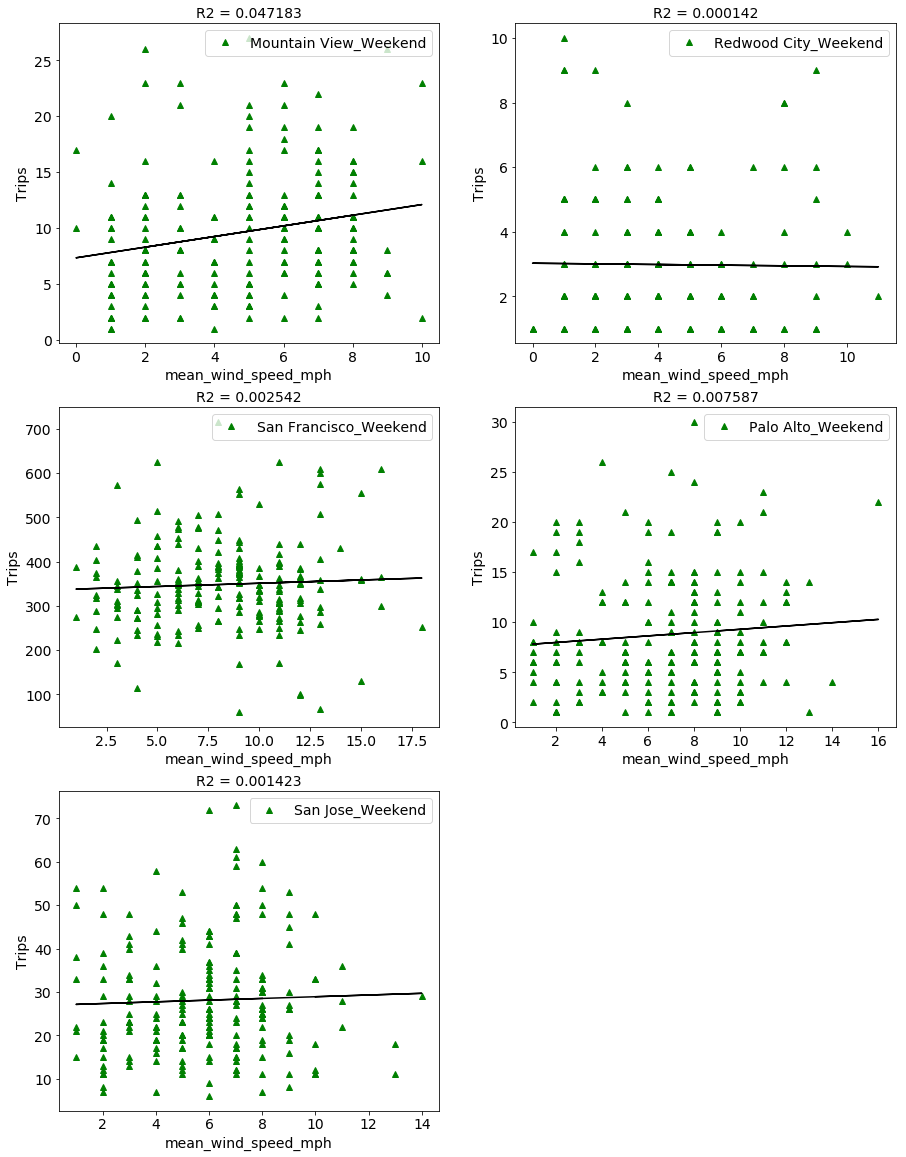

In [69]:
plt.clf()
fig = plt.figure(figsize=(15,20), facecolor='w')

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

plist = [ax1, ax2, ax3, ax4, ax5]
labellist = ['Mountain View_Weekend', 'Redwood City_Weekend', 'San Francisco_Weekend', 'Palo Alto_Weekend', 'San Jose_Weekend']
i = 0

for p in plist:
    p.plot(temper4[i].mean_wind_speed_mph, temper4[i].Frequency, '^', color ='g', label = labellist[i])
    p.plot(temper4[i].mean_wind_speed_mph, pred[i], '-', color = 'black')
    p.set_xlabel('mean_wind_speed_mph', fontsize =14)
    p.set_ylabel('Trips', fontsize=14)
    p.set_title('R2 = %f' % modellist[i].score(temper4[i].loc[:, ['mean_wind_speed_mph']], temper4[i].Frequency), fontsize=14)
    p.legend(loc = 'best', fontsize =14)
    p.tick_params(labelsize=14)
    i += 1

plt.show()

風の強さと一日当たりの需要の関連性はない模様<br>

In [70]:
df_station = pd.concat([df_station, station_install_date], axis =1)
#ステーション設置数の時間累積を出す
station = df_station.groupby('installation_date').size().reset_index()
station.columns = ['date', 'Num']
station.date = station.date.apply(lambda x: dt.strptime(x,'%m/%d/%Y'))
station = station.sort_values(by='date', ascending=True)
station['Cumsum'] = station.Num.cumsum()
station

,date,Num,Cumsum
14,2013-08-05,5,5
15,2013-08-06,5,10
16,2013-08-07,4,14
4,2013-08-12,4,18
5,2013-08-14,4,22
6,2013-08-15,5,27
7,2013-08-16,3,30
8,2013-08-19,6,36
9,2013-08-20,6,42
10,2013-08-21,5,47


機械学習用のトレーニングデータの整備<br>
結合データdf_allを訓練用データdf_learnに渡し、いらない変数を削除する<br>

In [71]:
df_learn = df_all

In [72]:
del df_learn['end_date']
del df_learn['end_station_id']
del df_learn['end_station_name']
del df_learn['duration']
del df_learn['dock_count']
del df_learn['zip_code_x']
del df_learn['zip_code_y']
del df_learn['start_station_name']
del df_learn['bike_id']
del df_learn['subscription_type']
del df_learn['date']
del df_learn['duration (Min)']
del df_learn['name']

ステーションID、年、月、日、時間、曜日、都市、経度、緯度、天気イベントでGroup byを行う<br>
各グループの需要数を算出<br>
各グループの天気変数の平均値を算出<br>
トレーニングデータ・セットとして生成（念のためcsvにも出力）<br>

In [73]:
group = df_learn.groupby(['start_station_id', 'Year', 'Month', 'Day', 'Weekflag', 'Timezone', 'city', 'lat', 'long', 'events'])

In [74]:
var_x = group['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f','min_dew_point_f',
      'max_humidity', 'mean_humidity', 'min_humidity', 'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles','mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches','cloud_cover', 'wind_dir_degrees'].mean().reset_index()

In [75]:
var_y = group.size().reset_index()
var_y = var_y.rename(columns={0: 'Frequency'})
train_set = pd.concat([var_x, var_y.Frequency], axis = 1)

残タスク：<br>
1.ダミー変数の生成（年、天気イベントなど）<br>
2.欠損値の除去<br>
3.モデルのインポート（SVM, KNN, NN, GB, RF, Tree)<br>
4.グリッドサーチによるパラメータチューニング<br>
5.最適モデルの提案<br>

In [76]:
train_set.events = train_set.events.str.replace('rain', 'Rain')
train_set = train_set.drop('max_gust_speed_mph', axis=1)

トレーニングデータのcsv出力<br>

In [77]:
train_set.to_csv('train_set.csv')

In [78]:
"""変数のダミー化"""
city = pd.get_dummies(train_set['city'])
events = pd.get_dummies(train_set['events'])
weekflag = pd.get_dummies(train_set['Weekflag'])
Zone = pd.get_dummies(train_set['Timezone'])
"""多重共線性を防ぐため幾つかのダミー変数を削除"""
train_set = train_set.drop('city', axis=1).drop('events', axis=1).drop('Weekflag', axis=1).drop('Timezone', axis=1)
train_set = pd.concat([train_set, city, events, weekflag, Zone], axis =1)

In [79]:
X_train = train_set.drop('Frequency', axis =1)
X_train = X_train.loc[:, ['lat', 'long', 'Year', 'Month', 'Day', 'Morning Rushhour', 'Noon',
                          'Eveing Rushhour', 'Weekend',
                          'mean_temperature_f', 'mean_humidity', 'mean_sea_level_pressure_inches',
                          'mean_visibility_miles', 'mean_wind_speed_mph','precipitation_inches',
                          'Fog', 'Fog-Rain', 'No_RainForg', 'Rain', 'cloud_cover']]
Y_train = train_set.Frequency

In [80]:
x1, x2, y1, y2 = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 2)

In [81]:
"""正規化する前に説明変数を別枠で確保"""
x_explain = x2

In [82]:
"""データの標準化"""
scaler = MinMaxScaler()
scaler.fit(x1)
x1 = scaler.transform(x1)
x2 = scaler.transform(x2)

In [83]:
"""モデルの読み込み"""
reg_linear = linear_model.LinearRegression()
reg_rige = linear_model.Ridge()
reg_lasso = linear_model.Lasso()
reg_rdfr = ensemble.RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
reg_gb = ensemble.GradientBoostingRegressor()
reg_adb = ensemble.AdaBoostRegressor()
reg_ner = neural_network.MLPRegressor(max_iter=500)
reg_tree = tree.DecisionTreeRegressor()

In [84]:
model_list =[reg_linear, reg_rige, reg_lasso, reg_rdfr, reg_gb, reg_adb, reg_tree]

In [85]:
for model in model_list:
    start = time()
    model.fit(x1, y1)
    print("Fit Time: {} s".format(time() - start))

Fit Time: 0.05715179443359375 s
Fit Time: 0.029152631759643555 s
Fit Time: 0.046883583068847656 s
Fit Time: 61.50764513015747 s
Fit Time: 6.908374547958374 s
Fit Time: 2.475717782974243 s
Fit Time: 0.728161096572876 s


In [86]:
model_name = ['Linear', 'Rige', 'Lasso', 'RandamForest', 'GradientBoosting', 'AdaBoosting', 'Decision Tree']

In [87]:
i=0
for model in model_list:
    print("Processing %s" % model_name[i])
    scores = cross_val_score(model, x1, y1, cv=5, scoring = 'neg_mean_squared_error')
    print("Cross validation scores:{}".format(scores.mean().round(3)))
    i += 1

Processing Linear
Cross validation scores:-40.048
Processing Rige
Cross validation scores:-40.048
Processing Lasso
Cross validation scores:-52.652
Processing RandamForest
Cross validation scores:-8.22
Processing GradientBoosting
Cross validation scores:-21.045
Processing AdaBoosting
Cross validation scores:-31.273
Processing Decision Tree
Cross validation scores:-16.609


In [ ]:
tuned_parameters_rdfr = {"max_depth": [2,3, None],
                         "n_estimators":[100, 200, 300],
                         "max_features": [1, 3, 5],
                         "min_samples_split": [2, 3, 10],
                         "min_samples_leaf": [1, 3, 10],
                         "bootstrap": [True, False],
                         }

In [ ]:
reg_rdfr = GridSearchCV(ensemble.RandomForestRegressor(),
                        param_grid=tuned_parameters_rdfr,
                        scoring='r2',
                        n_jobs=-1, verbose=3, cv=5)

In [ ]:
"""グリッドサーチの開始（フィッティング）"""
reg_rdfr.fit(x1, y1)

In [ ]:
print('Best Score %f' % reg_rdfr.best_score_)
print(reg_rdfr.best_estimator_)

In [88]:
reg_rdfr.score(x2, y2)

0.85115863468280195

In [89]:
"""予測結果と実結果、説明変数を同じデータフレームとして結合"""
y2 = pd.DataFrame(y2).reset_index(drop= True)
x2_p = reg_rdfr.predict(x2)
x2_p = pd.DataFrame(x2_p)
x2_p.columns = ['Predict_trip']
a = pd.concat([y2.Frequency, x2_p.Predict_trip], axis = 1)
x_explain = x_explain.reset_index(drop=True)
df_analysis = pd.concat([x_explain, a], axis=1)

df_analysis['Time'] = df_analysis.apply(lambda x: datetime.date(int(x.Year), int(x.Month), int(x.Day)), axis=1)

In [90]:
"""予測結果と実結果、説明変数を同じデータフレームとして結合"""
y2 = pd.DataFrame(y2).reset_index(drop= True)
x2_p = reg_rdfr.predict(x2)
x2_p = pd.DataFrame(x2_p)
x2_p.columns = ['Predict_trip']
a = pd.concat([y2.Frequency, x2_p.Predict_trip], axis = 1)
x_explain = x_explain.reset_index(drop=True)

df_analysis = pd.concat([x_explain, a], axis=1)
df_analysis['Time'] = df_analysis.apply(lambda x: datetime.date(int(x.Year), int(x.Month), int(x.Day)), axis=1)
df_analysis = df_analysis.groupby(['Time', 'Weekend'])['Frequency', 'Predict_trip'].sum().reset_index()

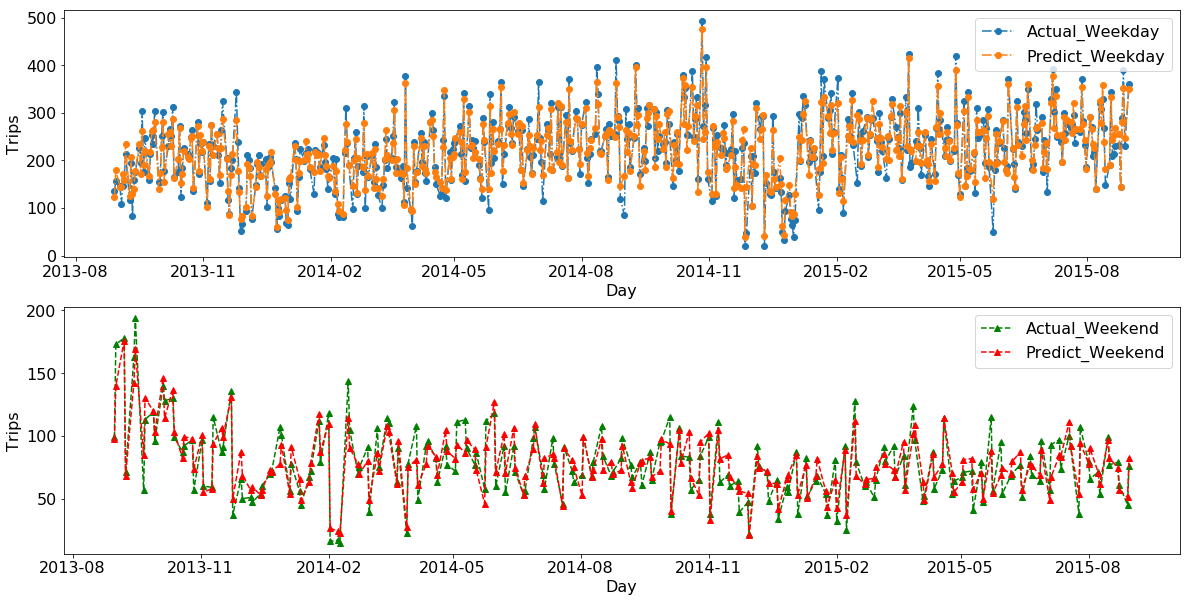

In [118]:
plt.clf()
fig = plt.figure(figsize=(20,10),facecolor='w')
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(df_analysis[df_analysis['Weekend'] == 0].Time, df_analysis[df_analysis['Weekend'] == 0].Frequency, 'o-.', label = 'Actual_Weekday')
ax1.plot(df_analysis[df_analysis['Weekend'] == 0].Time, df_analysis[df_analysis['Weekend'] == 0].Predict_trip, 'o-.',label = 'Predict_Weekday')
ax2.plot(df_analysis[df_analysis['Weekend'] == 1].Time, df_analysis[df_analysis['Weekend'] == 1].Frequency, '^--', label = 'Actual_Weekend', color = 'g')
ax2.plot(df_analysis[df_analysis['Weekend'] == 1].Time, df_analysis[df_analysis['Weekend'] == 1].Predict_trip, '^--', label = 'Predict_Weekend', color = 'r')

ax1.set_xlabel('Day', fontsize =16)
ax1.set_ylabel('Trips', fontsize = 16)
ax2.set_xlabel('Day', fontsize =16)
ax2.set_ylabel('Trips', fontsize = 16)
ax1.legend(loc='upper right', fontsize =16)
ax2.legend(loc='upper right', fontsize =16)

ax1.tick_params(labelsize = 16)
ax2.tick_params(labelsize = 16)
plt.show()


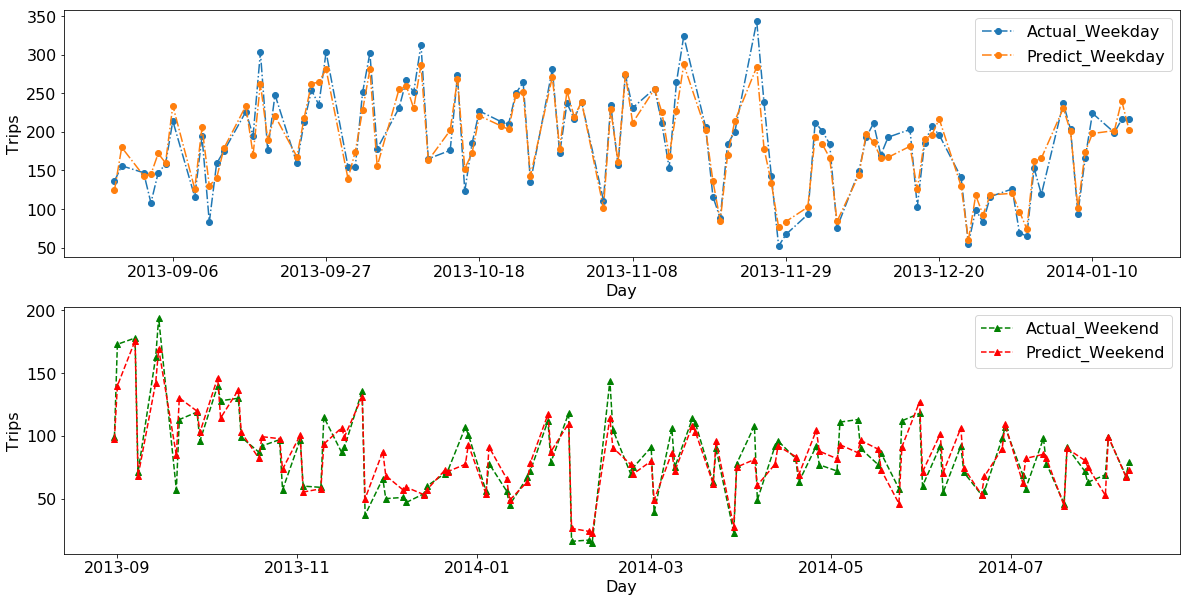

In [92]:
plt.clf()
fig = plt.figure(figsize=(20,10),facecolor='w')

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(df_analysis[df_analysis['Weekend'] == 0].Time.head(100), df_analysis[df_analysis['Weekend'] == 0].Frequency.head(100), 'o-.', label = 'Actual_Weekday')
ax1.plot(df_analysis[df_analysis['Weekend'] == 0].Time.head(100), df_analysis[df_analysis['Weekend'] == 0].Predict_trip.head(100), 'o-.',label = 'Predict_Weekday')
ax2.plot(df_analysis[df_analysis['Weekend'] == 1].Time.head(100), df_analysis[df_analysis['Weekend'] == 1].Frequency.head(100), '^--', label = 'Actual_Weekend', color = 'g')
ax2.plot(df_analysis[df_analysis['Weekend'] == 1].Time.head(100), df_analysis[df_analysis['Weekend'] == 1].Predict_trip.head(100), '^--', label = 'Predict_Weekend', color = 'r')

ax1.set_xlabel('Day', fontsize =16)
ax1.set_ylabel('Trips', fontsize = 16)
ax2.set_xlabel('Day', fontsize =16)
ax2.set_ylabel('Trips', fontsize = 16)
ax1.legend(loc='best', fontsize =16)
ax2.legend(loc='best', fontsize =16)

ax1.tick_params(labelsize = 16)
ax2.tick_params(labelsize = 16)
plt.show()

残りタスク：<br>
一日ごとの需要実績（平日、週末で色分け）のグラフを書く<br>
平日の平均需要を計算する<br>
休日の平均需要を計算する<br>

In [93]:
"""一日おきの需要グラフを書くためのデータフレーム処理"""
train_analysis = train_set
train_analysis['Time'] = train_analysis.apply(lambda x: datetime.date(int(x.Year), int(x.Month), int(x.Day)), axis=1)
train_visual = train_analysis.groupby(['Time', 'Weekend'])['Frequency'].sum().reset_index()

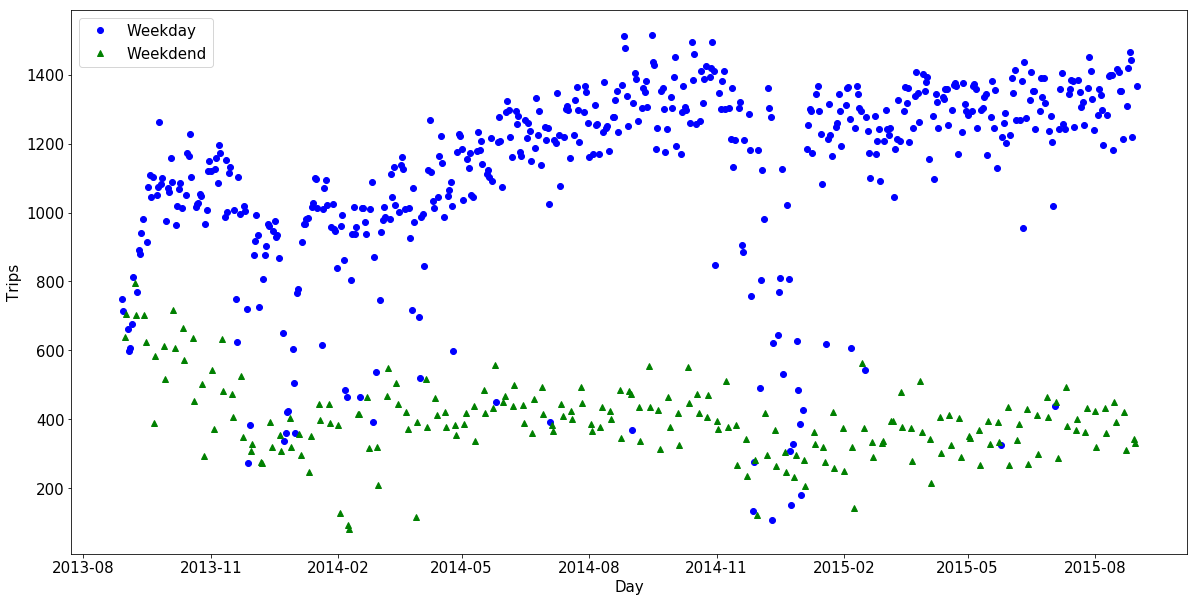

In [114]:
plt.clf()
fig = plt.figure(figsize=(20,10),facecolor='w')
plt.plot(train_visual[train_visual['Weekend'] == 0].Time, train_visual[train_visual['Weekend'] == 0].Frequency, 'o', color = 'b', label = 'Weekday')
plt.plot(train_visual[train_visual['Weekend'] == 1].Time, train_visual[train_visual['Weekend'] == 1].Frequency, '^', color = 'g',label = 'Weekdend')
plt.xlabel('Day', fontsize = 15)
plt.ylabel('Trips', fontsize = 15)
plt.legend(loc='best', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

In [95]:
"""訓練データの緯度・経度データをもとに、ステーションIDを結合"""
station_dict = df_station.loc[:, ['start_station_id', 'lat', 'long', 'city']]
x_explain_new = pd.merge(x_explain, station_dict, on=['lat', 'long'], how='left')
df_analysis_new = pd.concat([x_explain_new, a], axis=1)
df_analysis_new['Time'] = df_analysis_new.apply(lambda x: datetime.date(int(x.Year), int(x.Month), int(x.Day)), axis=1)

In [96]:
t1 = list(0 for i in range(5))

In [97]:
"""都市別平日のデータを抽出"""
t1[0] = df_analysis_new[(df_analysis_new['city'] == 'Mountain View') & (df_analysis_new['Weekend'] == 0)]
t1[1] = df_analysis_new[(df_analysis_new['city'] == 'Redwood City') & (df_analysis_new['Weekend'] == 0)]
t1[2] = df_analysis_new[(df_analysis_new['city'] == 'San Francisco') & (df_analysis_new['Weekend'] == 0)]
t1[3] = df_analysis_new[(df_analysis_new['city'] == 'Palo Alto') & (df_analysis_new['Weekend'] == 0)]
t1[4] = df_analysis_new[(df_analysis_new['city'] == 'San Jose') & (df_analysis_new['Weekend'] == 0)]

In [98]:
"""時間帯のフラグをつける（朝ラッシュ、昼、夜ラッシュ、深夜）"""
def covert_timezone(x):
    if x['Morning Rushhour'] == 1:
        return 'Morning'
    elif x['Noon'] == 1:
        return 'Noon'
    elif x['Eveing Rushhour'] == 1:
        return 'Evening'
    else:
        return 'Night'

for i in range(5):
    t1[i]['Timezone'] = t1[i].apply(lambda x: covert_timezone(x), axis=1)

C:\Users\zhaow\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [99]:
t2 = list(0 for i in range(5))

In [100]:
"""時間、時間帯、都市ごとに実需要と予測需要を別データフレームに格納"""
for i in range(5):
    t2[i] = t1[i].groupby(['Time', 'Timezone', 'city'])['Frequency', 'Predict_trip'].sum().reset_index()

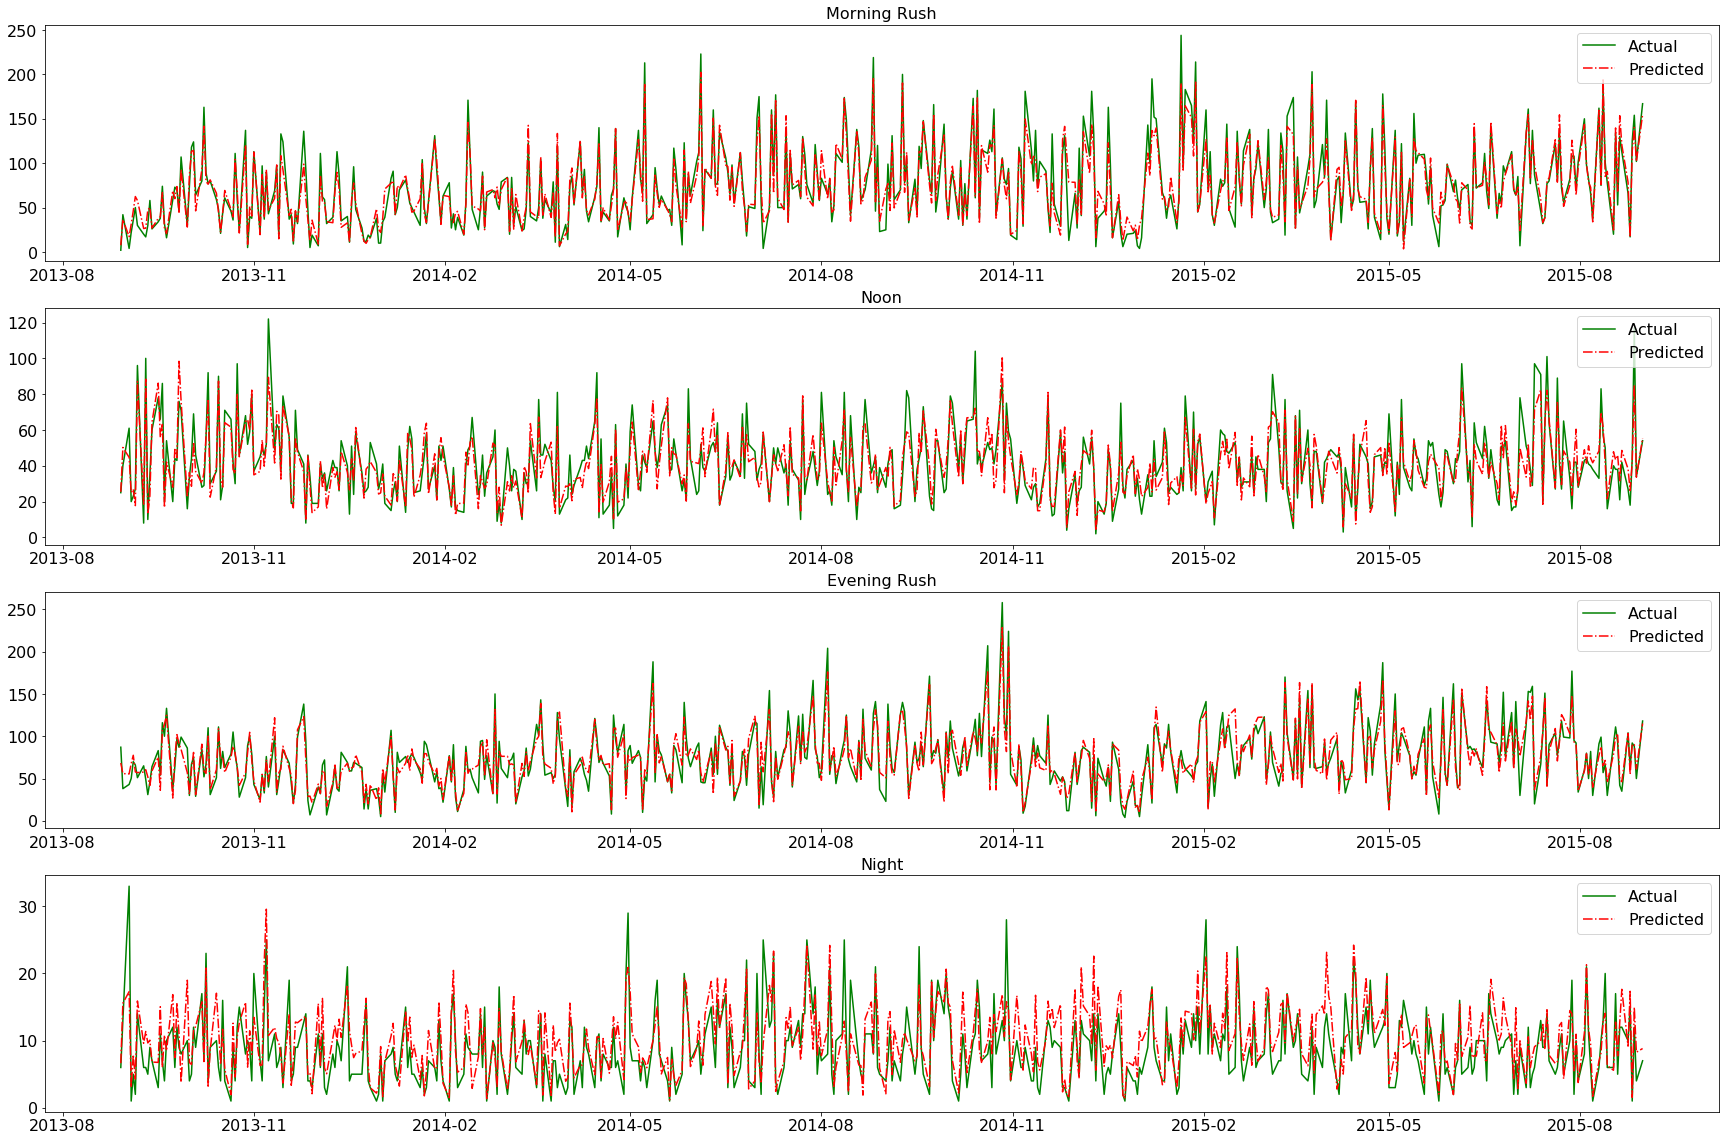

In [101]:
plt.clf()
fig = plt.figure(figsize=(30,20), facecolor='w')

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

"""San Francisco市のデータを抽出"""
i = 2 

ax1.plot(t2[i][t2[i]['Timezone'] == 'Morning'].Time, t2[i][t2[i]['Timezone'] == 'Morning'].Frequency, '-', label = 'Actual', color = 'g')
ax1.plot(t2[i][t2[i]['Timezone'] == 'Morning'].Time, t2[i][t2[i]['Timezone'] == 'Morning'].Predict_trip, '-.', label = 'Predicted', color ='r')

ax2.plot(t2[i][t2[i]['Timezone'] == 'Noon'].Time, t2[i][t2[i]['Timezone'] == 'Noon'].Frequency, '-', label = 'Actual', color = 'g')
ax2.plot(t2[i][t2[i]['Timezone'] == 'Noon'].Time, t2[i][t2[i]['Timezone'] == 'Noon'].Predict_trip, '-.', label = 'Predicted', color ='r')

ax3.plot(t2[i][t2[i]['Timezone'] == 'Evening'].Time, t2[i][t2[i]['Timezone'] == 'Evening'].Frequency, '-',label = 'Actual', color = 'g')
ax3.plot(t2[i][t2[i]['Timezone'] == 'Evening'].Time, t2[i][t2[i]['Timezone'] == 'Evening'].Predict_trip, '-.', label = 'Predicted',color ='r')

ax4.plot(t2[i][t2[i]['Timezone'] == 'Night'].Time, t2[i][t2[i]['Timezone'] == 'Night'].Frequency, '-', label = 'Actual', color = 'g')
ax4.plot(t2[i][t2[i]['Timezone'] == 'Night'].Time, t2[i][t2[i]['Timezone'] == 'Night'].Predict_trip, '-.', label = 'Predicted', color ='r')

ax1.set_title('Morning Rush', fontsize = 16)
ax2.set_title('Noon', fontsize = 16)
ax3.set_title('Evening Rush', fontsize = 16)
ax4.set_title('Night', fontsize = 16)

ax1.legend(loc = 'upper right', fontsize=16)
ax2.legend(loc = 'upper right', fontsize=16)
ax3.legend(loc = 'upper right', fontsize=16)
ax4.legend(loc = 'upper right', fontsize=16)
ax5.legend(loc = 'upper right', fontsize=16)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)

plt.show()

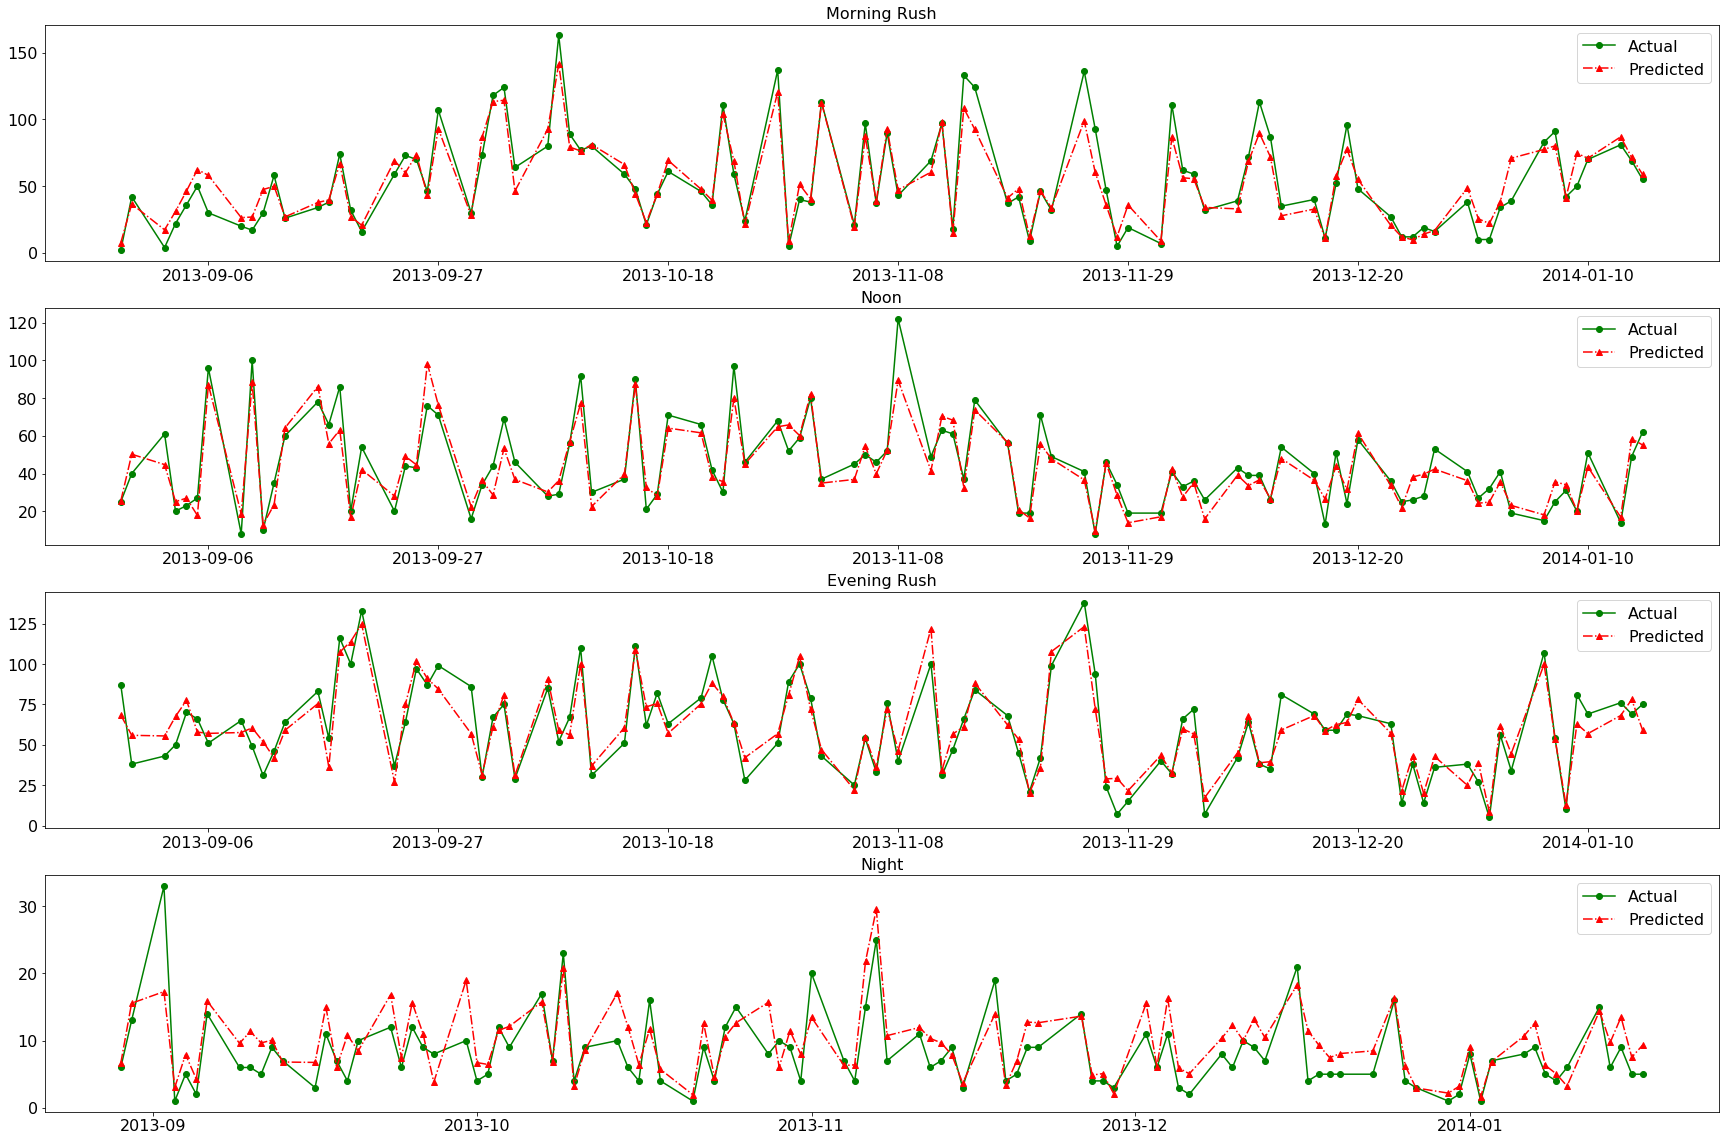

In [113]:
plt.clf()
fig = plt.figure(figsize=(30,20), facecolor='w')

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

"""San Francisco市のデータを抽出"""
i = 2 

ax1.plot(t2[i][t2[i]['Timezone'] == 'Morning'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Morning'].Frequency.head(100), 'o-', label = 'Actual', color = 'g')
ax1.plot(t2[i][t2[i]['Timezone'] == 'Morning'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Morning'].Predict_trip.head(100), '^-.', label = 'Predicted', color ='r')

ax2.plot(t2[i][t2[i]['Timezone'] == 'Noon'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Noon'].Frequency.head(100), 'o-', label = 'Actual', color = 'g')
ax2.plot(t2[i][t2[i]['Timezone'] == 'Noon'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Noon'].Predict_trip.head(100), '^-.', label = 'Predicted', color ='r')

ax3.plot(t2[i][t2[i]['Timezone'] == 'Evening'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Evening'].Frequency.head(100), 'o-',label = 'Actual', color = 'g')
ax3.plot(t2[i][t2[i]['Timezone'] == 'Evening'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Evening'].Predict_trip.head(100), '^-.', label = 'Predicted',color ='r')

ax4.plot(t2[i][t2[i]['Timezone'] == 'Night'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Night'].Frequency.head(100), 'o-', label = 'Actual', color = 'g')
ax4.plot(t2[i][t2[i]['Timezone'] == 'Night'].Time.head(100), t2[i][t2[i]['Timezone'] == 'Night'].Predict_trip.head(100), '^-.', label = 'Predicted', color ='r')

ax1.set_title('Morning Rush', fontsize = 16)
ax2.set_title('Noon', fontsize = 16)
ax3.set_title('Evening Rush', fontsize = 16)
ax4.set_title('Night', fontsize = 16)

ax1.legend(loc = 'upper right', fontsize=16)
ax2.legend(loc = 'upper right', fontsize=16)
ax3.legend(loc = 'upper right', fontsize=16)
ax4.legend(loc = 'upper right', fontsize=16)
ax5.legend(loc = 'upper right', fontsize=16)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)

plt.show()

In [102]:
"""価格弾性値=10を仮定した時の価格変動値を計算"""
b1 = (t2[i][t2[i]['Timezone'] == 'Morning'].Predict_trip / 2.72) /10
b2 = (t2[i][t2[i]['Timezone'] == 'Noon'].Predict_trip / 2.72) /10
b3 = (t2[i][t2[i]['Timezone'] == 'Evening'].Predict_trip / 2.72) /10
b4 = (t2[i][t2[i]['Timezone'] == 'Night'].Predict_trip / 4.90) /10

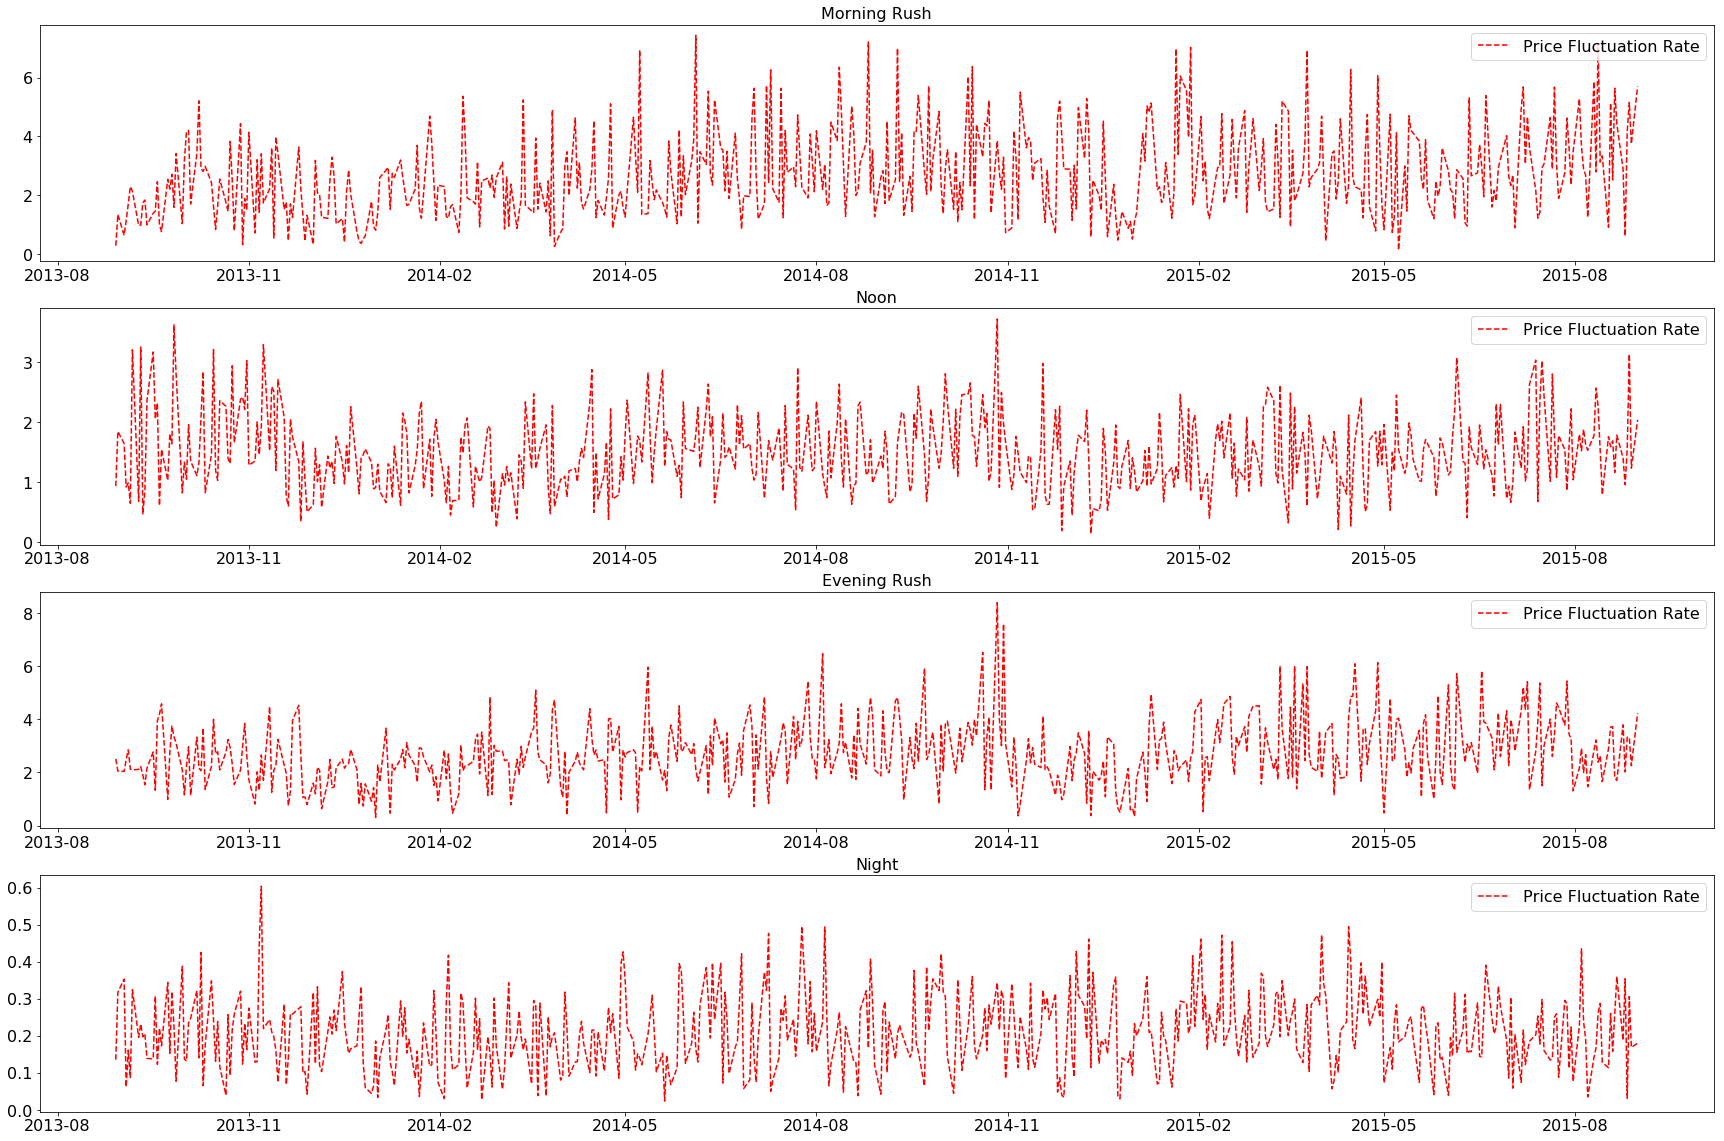

In [103]:
plt.clf()
fig = plt.figure(figsize=(30,20), facecolor='w')

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

i = 2

ax1.plot(t2[i][t2[i]['Timezone'] == 'Morning'].Time, b1, '--', color = 'r', label = 'Price Fluctuation Rate')
ax2.plot(t2[i][t2[i]['Timezone'] == 'Noon'].Time, b2, '--', color = 'r', label = 'Price Fluctuation Rate')
ax3.plot(t2[i][t2[i]['Timezone'] == 'Evening'].Time, b3, '--', color = 'r', label = 'Price Fluctuation Rate')
ax4.plot(t2[i][t2[i]['Timezone'] == 'Night'].Time, b4, '--', color = 'r', label = 'Price Fluctuation Rate')

ax1.set_title('Morning Rush', fontsize = 16)
ax2.set_title('Noon', fontsize = 16)
ax3.set_title('Evening Rush', fontsize = 16)
ax4.set_title('Night', fontsize = 16)

ax1.legend(loc = 'upper right', fontsize=16)
ax2.legend(loc = 'upper right', fontsize=16)
ax3.legend(loc = 'upper right', fontsize=16)
ax4.legend(loc = 'upper right', fontsize=16)
ax5.legend(loc = 'upper right', fontsize=16)

ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax4.tick_params(labelsize=16)
ax5.tick_params(labelsize=16)

plt.show()

In [104]:
"""ランダムフォレストの重要度係数を出力"""
reg_rdfr.feature_importances_

array([ 0.24150037,  0.2905276 ,  0.02636123,  0.0178217 ,  0.01536833,
        0.1159909 ,  0.02572894,  0.07593647,  0.1046187 ,  0.01858209,
        0.01406216,  0.01517411,  0.00415447,  0.01481359,  0.00521947,
        0.00098901,  0.0004709 ,  0.00140517,  0.00133262,  0.00994217])

In [105]:
variable = pd.DataFrame(x_explain.columns)
importance = pd.DataFrame(reg_rdfr.feature_importances_)

In [106]:
rd_importance = pd.concat([variable, importance], axis = 1)
rd_importance.columns = ['Variable', 'Importance']
rd_importance = rd_importance.sort_values(by = ['Importance'], ascending=True).reset_index(drop = True)

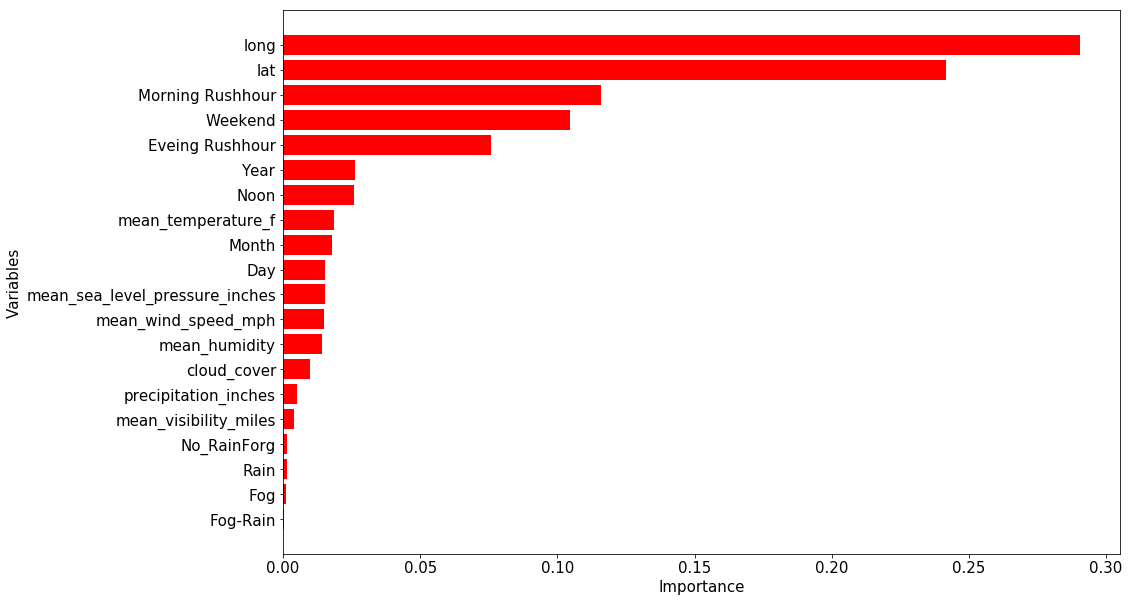

In [107]:
plt.clf()
fig = plt.figure(figsize=(15,10), facecolor='w')
plt.barh(range(20), rd_importance.Importance, color = 'red')
plt.yticks(range(20), rd_importance.Variable)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Variables', fontsize = 15)
plt.legend(loc='best', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

In [108]:
df_station.groupby('city').size()

city
Mountain View     7
Palo Alto         5
Redwood City      7
San Francisco    35
San Jose         16
dtype: int64

In [109]:
train_set.groupby('Time').Frequency.sum().mean() /70 / (24/9)

4.896406645877997